# AutoGluon 모델 기반 경제지표를 이용한 경기 흐름 예측

# [0] 데이터 분석 준비

### 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 코랩 환경 한글 글꼴 설치, 설치 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,777 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and dire

### 서드파티 모듈 설치

In [1]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### 모듈 로드

In [214]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.rc('font', family='NanumBarunGothic')

In [215]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

### 데이터 로드

In [216]:
eco_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/경제지표데이터/finance_final_68.csv', encoding = 'utf-8')

In [217]:
eco_df

,날짜,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,2003-01-01,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,2003-02-01,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000
2,2003-03-01,53.8,-1.8,98.5,87.6,7904.5,149.7,591.1,0.72,57.7,...,106.39,82,87,97.0,1,1.25,1.573810,2.783810,3.807143,4.816190
3,2003-04-01,53.7,-6.2,97.5,86.3,7858.6,150.3,576.1,0.61,57.6,...,106.39,71,45,91.0,0,1.26,1.622381,2.928571,3.958571,4.911905
4,2003-05-01,53.7,-8.5,95.5,85.4,7624.8,151.2,583.4,0.53,57.8,...,106.39,71,45,91.0,1,1.26,1.415238,2.515714,3.569048,4.521429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-05-01,109.8,-17.2,93.2,99.9,10466.3,84.5,2488.4,-0.15,110.3,...,96.52,64,88,98.0,1,5.06,4.131818,3.591364,3.573636,3.963636
245,2023-06-01,110.5,-13.0,94.6,99.0,11826.5,86.0,2548.9,-0.16,110.3,...,101.64,69,89,100.7,1,5.08,4.639524,3.949524,3.748095,4.041905
246,2023-07-01,111.1,-9.6,94.7,99.3,12177.8,86.6,2572.6,-0.04,110.0,...,102.08,75,91,103.2,1,5.12,4.828500,4.141500,3.899500,4.149500
247,2023-08-01,111.4,-7.9,94.6,98.4,9882.9,86.8,2585.1,0.12,110.0,...,99.03,72,91,103.1,1,5.33,4.901739,4.306522,4.167826,4.456522


### NA 처리

In [218]:
eco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   날짜                          249 non-null    object 
 1   선행종합지수(2020=100)            249 non-null    float64
 2   재고순환지표(%p)                  249 non-null    float64
 3   경제심리지수                      249 non-null    float64
 4   기계류내수출하지수(선박제외)(2020=100)   249 non-null    float64
 5   건설수주액(실질)(십억원)              249 non-null    float64
 6   수출입물가비율(2015=100)           249 non-null    float64
 7   코스피(1980.1.4=100)           249 non-null    float64
 8   장단기금리차(%p)                  249 non-null    float64
 9   동행종합지수(2020=100)            249 non-null    float64
 10  광공업생산지수(2020=100)           249 non-null    float64
 11  서비스업생산지수(도소매업제외)(2020=100)  249 non-null    float64
 12  건설기성액(실질)(십억원)              249 non-null    float64
 13  소매판매액지수(2020=100)           249 non

In [219]:
# fillna
#eco_df = eco_df.fillna(method = 'bfill').fillna(method = 'ffill')

### 수치형 변수만 사용

In [220]:
eco_num_df = eco_df.select_dtypes(include=['number'])
eco_num_df.head(2)

,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),광공업생산지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,51.6,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,51.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000


# [1] Random Forest Regressor를 이용한 피쳐 중요도 파악
- 종속변수 : 기준금리
- 독립변수 : 기준금리 외 다른 변수

### 학습 준비

- target, X 분리

In [221]:
target = eco_num_df['미_금리']
eco_df_for_lr = eco_num_df.drop(['미_금리'], axis = 1)

- Scaling

    - % 단위의 칼럼 + 기타 : MinMaxScaler
    - 일반 수치형, 100기준 칼럼 : StandardScaler

- % 단위 칼럼 : ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy', ' '미_coremom', '미_coreyoy', '콜금리', '미_금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20' 재고순환지표(%p), 장단기금리차(%p), CP유통수익률(%p), GDP 성장률 (%)]
<br/>

- 100기준 칼럼 : [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스'
,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)'
,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
<br/>

- 금액/인원 단위 칼럼 : ['건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)']

<br/>
- 기타 : ['미_cpi','미_corecpi', 'South Korea', 'United States of America']

In [222]:
std_cols =   [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스' ,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)' ,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
std_scaler = StandardScaler()
eco_df_for_lr[std_cols] = std_scaler.fit_transform(eco_df_for_lr[std_cols])

In [224]:
minmax_cols = ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy',  '미_coremom', '미_coreyoy', '콜금리', '기준금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20', '재고순환지표(%p)', '장단기금리차(%p)', 'CP유통수익률(%p)', 'GDP 성장률 (%)', '건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)','미_cpi','미_corecpi', 'South Korea', 'United States of America']
minmax_scaler = MinMaxScaler()
eco_df_for_lr[minmax_cols] = minmax_scaler.fit_transform(eco_df_for_lr[minmax_cols])

### 모델 학습

In [225]:
rf = RandomForestRegressor()

rf.fit(eco_df_for_lr, target)

RandomForestRegressor()

### 피쳐중요도 확인

In [226]:
# 피쳐 중요도 확인
feature_importances = rf.feature_importances_

# 피쳐 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 각 피쳐의 중요도 출력
for f in range(eco_df_for_lr.shape[1]):
    print(f"{eco_df_for_lr.columns[indices[f]]}: {feature_importances[indices[f]]}")

미국채_2: 0.8924330363101871
CP유통수익률(%p): 0.023475504678269053
뉴스심리지수: 0.011750236951995216
기준금리: 0.010231263274217773
콜금리: 0.009750326720973153
미국채_5: 0.008695973373151013
미_coremom: 0.0056351780159771235
장단기금리차(%p): 0.0047014444792165665
원달러환율: 0.0040236861623060005
경제심리지수: 0.0021814273583438573
수출입물가비율(2015=100): 0.002035081790808496
동행지수순환변동치: 0.00203096630651294
미_실업률: 0.001427394676468439
건설기성액(실질)(십억원): 0.001422242162462562
소비자물가지수변화율(서비스): 0.001377174209063652
선행지수순환변동치: 0.0012317753529993893
미_yoy: 0.0010385039494615479
달러인덱스: 0.0010216180090930874
코스피(1980.1.4=100): 0.0010070333966240362
식료품 및 에너지제외 지수: 0.000916300716075726
실_30-39세: 0.0006940073459368944
South Korea: 0.0006240824065960637
재고순환지표(%p): 0.000588197442371645
BSI_제조업: 0.0005872188102050565
미_cpi: 0.0005777994372587902
건설수주액(실질)(십억원): 0.0005701534780426294
비농림어업취업자수(천명): 0.0005432063972361237
BSI_전산업: 0.0005388621636690383
소비재수입액(실질)(백만불): 0.0005357005013113936
광공업생산지수(2020=100): 0.0005269619334153117
현재경기판단: 0.00048

### 피쳐 Selection

- 랜덤포래스트 학습 결과 상위 20개 피쳐
- EDA를 바탕으로 높은 연관성을 보이는 피쳐 직접 추가

In [227]:
top_20_features = eco_df_for_lr.columns[indices[:20]].tolist() #+ ['경제심리지수','소비자물가지수변화율(서비스)', '뉴스심리지수','현재경기판단']
top_20_features

['미국채_2',
 'CP유통수익률(%p)',
 '뉴스심리지수',
 '기준금리',
 '콜금리',
 '미국채_5',
 '미_coremom',
 '장단기금리차(%p)',
 '원달러환율',
 '경제심리지수',
 '수출입물가비율(2015=100)',
 '동행지수순환변동치',
 '미_실업률',
 '건설기성액(실질)(십억원)',
 '소비자물가지수변화율(서비스)',
 '선행지수순환변동치',
 '미_yoy',
 '달러인덱스',
 '코스피(1980.1.4=100)',
 '식료품 및 에너지제외 지수']

In [228]:
eco_df_for_ts = eco_df_for_lr[top_20_features]
#eco_df_for_ts = eco_df_for_ts.drop(['콜금리'], axis = 1)

# [2] 시계열 분석

- 회귀분석 피쳐중요도 바탕으로 시계열 예측

### 전처리

In [229]:
eco_df_for_ts

,미국채_2,CP유통수익률(%p),뉴스심리지수,기준금리,콜금리,미국채_5,미_coremom,장단기금리차(%p),원달러환율,경제심리지수,수출입물가비율(2015=100),동행지수순환변동치,미_실업률,건설기성액(실질)(십억원),소비자물가지수변화율(서비스),선행지수순환변동치,미_yoy,달러인덱스,코스피(1980.1.4=100),식료품 및 에너지제외 지수
0,0.325188,0.590164,0.615201,0.789474,0.803383,0.580284,0.224837,0.393651,-0.555207,0.170202,2.410149,1.062010,0.212389,0.250147,0.682927,0.163093,0.433008,-0.152880,-2.143180,-1.825437
1,0.302130,0.606557,0.615201,0.789474,0.807611,0.548103,0.197885,0.346032,0.607611,0.033288,2.447482,0.673983,0.221239,0.239756,0.731707,-0.141483,0.468688,-0.180872,-2.159945,-1.806440
2,0.291327,0.622951,0.615201,0.789474,0.794926,0.524339,0.188977,0.307937,1.180553,-0.135223,2.490147,0.382963,0.221239,0.234879,0.804878,-0.344534,0.457591,-0.208015,-2.166788,-1.736655
3,0.301029,0.655738,0.615201,0.789474,0.794926,0.554493,0.144580,0.273016,0.810822,-0.240542,2.522146,-0.199078,0.230088,0.219194,0.878049,-0.750635,0.379543,-0.325919,-2.192449,-1.717561
4,0.259655,0.672131,0.615201,0.736842,0.758985,0.468492,0.152907,0.247619,0.722388,-0.451180,2.570145,-0.199078,0.238938,0.225174,0.902439,-0.953686,0.353746,-0.386992,-2.179961,-1.711261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.802259,0.491803,-0.422340,0.631579,0.653277,0.692558,0.782406,0.031746,1.863568,-0.693414,-0.987089,0.285956,0.026549,0.784433,0.902439,-1.461312,0.558919,1.519423,1.079000,1.817037
245,0.903667,0.491803,0.115878,0.631579,0.652431,0.767165,0.704976,0.028571,1.774193,-0.545967,-0.907091,0.091942,0.017699,0.781909,0.853659,-1.156736,0.463724,1.507138,1.182500,1.823822
246,0.941413,0.491803,0.162131,0.631579,0.640592,0.807155,0.679147,0.066667,1.368712,-0.535435,-0.875092,-0.393092,0.008850,0.773429,0.780488,-0.750635,0.482736,1.411663,1.223044,1.849022
247,0.956042,0.491803,-0.158487,0.631579,0.646512,0.841530,0.626984,0.117460,1.812765,-0.545967,-0.864426,-0.587105,0.035398,0.786026,0.731707,-0.750635,0.520235,1.563828,1.244428,1.877130


- AutoGluon 타임시리즈 예측을 위한 처리
    - 날짜를 나타내는 'timestamp' 칼럼과 각 값을 구분하는 'item' 칼럼이 반드시 필요
    - item은 여기서 0으로 통일해도 무방하다.

In [230]:
eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
eco_df_for_ts['item_id'] = 0
eco_df_for_ts['미_금리'] = target

<ipython-input-230-02e2816d11ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
<ipython-input-230-02e2816d11ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['item_id'] = 0
<ipython-input-230-02e2816d11ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [231]:
eco_df_for_ts

,미국채_2,CP유통수익률(%p),뉴스심리지수,기준금리,콜금리,미국채_5,미_coremom,장단기금리차(%p),원달러환율,경제심리지수,...,건설기성액(실질)(십억원),소비자물가지수변화율(서비스),선행지수순환변동치,미_yoy,달러인덱스,코스피(1980.1.4=100),식료품 및 에너지제외 지수,timestamp,item_id,미_금리
0,0.325188,0.590164,0.615201,0.789474,0.803383,0.580284,0.224837,0.393651,-0.555207,0.170202,...,0.250147,0.682927,0.163093,0.433008,-0.152880,-2.143180,-1.825437,2003-01-01,0,1.24
1,0.302130,0.606557,0.615201,0.789474,0.807611,0.548103,0.197885,0.346032,0.607611,0.033288,...,0.239756,0.731707,-0.141483,0.468688,-0.180872,-2.159945,-1.806440,2003-02-01,0,1.26
2,0.291327,0.622951,0.615201,0.789474,0.794926,0.524339,0.188977,0.307937,1.180553,-0.135223,...,0.234879,0.804878,-0.344534,0.457591,-0.208015,-2.166788,-1.736655,2003-03-01,0,1.25
3,0.301029,0.655738,0.615201,0.789474,0.794926,0.554493,0.144580,0.273016,0.810822,-0.240542,...,0.219194,0.878049,-0.750635,0.379543,-0.325919,-2.192449,-1.717561,2003-04-01,0,1.26
4,0.259655,0.672131,0.615201,0.736842,0.758985,0.468492,0.152907,0.247619,0.722388,-0.451180,...,0.225174,0.902439,-0.953686,0.353746,-0.386992,-2.179961,-1.711261,2003-05-01,0,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.802259,0.491803,-0.422340,0.631579,0.653277,0.692558,0.782406,0.031746,1.863568,-0.693414,...,0.784433,0.902439,-1.461312,0.558919,1.519423,1.079000,1.817037,2023-05-01,0,5.06
245,0.903667,0.491803,0.115878,0.631579,0.652431,0.767165,0.704976,0.028571,1.774193,-0.545967,...,0.781909,0.853659,-1.156736,0.463724,1.507138,1.182500,1.823822,2023-06-01,0,5.08
246,0.941413,0.491803,0.162131,0.631579,0.640592,0.807155,0.679147,0.066667,1.368712,-0.535435,...,0.773429,0.780488,-0.750635,0.482736,1.411663,1.223044,1.849022,2023-07-01,0,5.12
247,0.956042,0.491803,-0.158487,0.631579,0.646512,0.841530,0.626984,0.117460,1.812765,-0.545967,...,0.786026,0.731707,-0.750635,0.520235,1.563828,1.244428,1.877130,2023-08-01,0,5.33


### 3개월 단위 예측

#### - Validation : [MSE : 0.0001]

- train test split

In [232]:
train = eco_df_for_ts.iloc[: 246, :]
test = eco_df_for_ts.iloc[246 :, :]

train.shape, test.shape

((246, 23), (3, 23))

In [233]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2023-02-01  0.882527     0.639344 -0.321424  0.631579  0.622622   
        2023-03-01  0.836373     0.557377 -0.669374  0.631579  0.622622   
        2023-04-01  0.779126     0.508197 -0.578970  0.631579  0.631501   
        2023-05-01  0.802259     0.491803 -0.422340  0.631579  0.653277   
        2023-06-01  0.903667     0.491803  0.115878  0.631579  0.652431   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2023-02-01  0.765620   0.815081    0.136508  1.820291 -0.914584  ...   
        2023-03-01  0.740909   0.827757    0.101587  1.625548 -0.914584  ...   
        2023-04-01  0.681233   0.816845    0.063492  1.962351 -0.788201  ...   
        2023-05-01  0.692558   0.782406    0.031746  1.863568 -0.693414  ...   
        2023-06-01  0.767165   0.704976    0.028571  1.774193 -0.545967  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2023-02-01  -0.393092  0.017699        0.766641         0.926829   
        2023-03-01   0.091942  0.008850        0.801662         0.902439   
        2023-04-01   0.285956  0.000000        0.804750         0.926829   
        2023-05-01   0.285956  0.026549        0.784433         0.902439   
        2023-06-01   0.091942  0.017699        0.781909         0.853659   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2023-02-01  -1.055211  0.729470  1.558476           0.912887   
        2023-03-01  -1.359787  0.637701  1.600073           0.945049   
        2023-04-01  -1.562837  0.634972  1.482362           1.036744   
        2023-05-01  -1.461312  0.558919  1.519423           1.079000   
        2023-06-01  -1.156736  0.463724  1.507138           1.182500   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

- AutoGluon 자동화 시계열 예측 모델 학습

In [234]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_051909'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.50 GB / 12.68 GB (82.8%)
Disk Space Avail:   191.55 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 246 rows, 1 time series. Median time series length is 246 (min=246, max=246). 

Provided dat

- 전체 데이터를 대상으로 다시 학습

In [235]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- valid 예측

In [236]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [238]:
# 원래값
test['미_금리']

246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [239]:
# 예측값
pred.reset_index()['mean']

0    5.083905
1    5.103068
2    5.110232
Name: mean, dtype: float64

In [240]:
valid_3 = pred.reset_index()['mean']

In [244]:
round(mean_squared_error(test['미_금리'], pred.reset_index()['mean']), 4)

0.0337

In [245]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[246:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[246: , :]

<ipython-input-248-33a6b42d7c8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


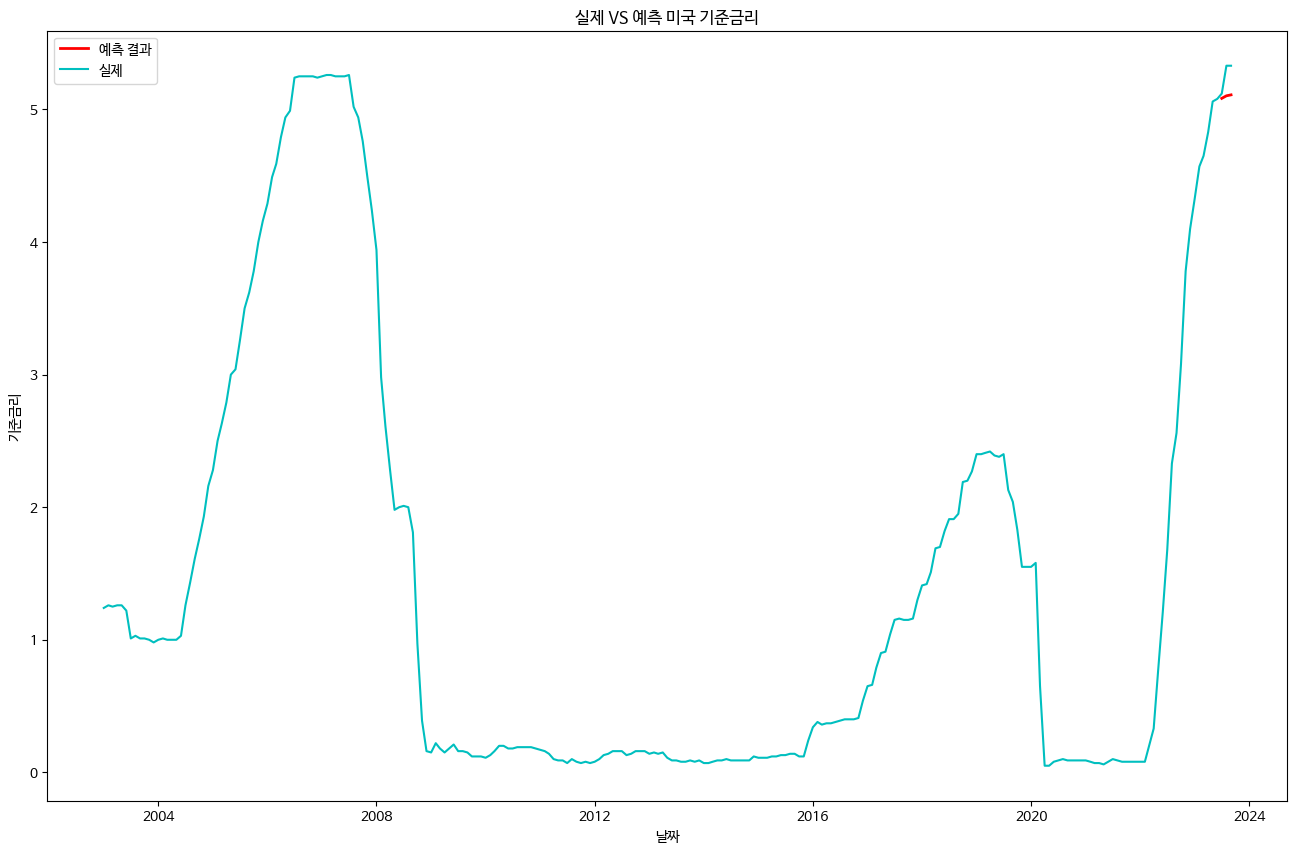

In [248]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [249]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_052148'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.41 GB / 12.68 GB (82.1%)
Disk Space Avail:   191.54 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided dat

In [250]:
pred_3 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [251]:
for_plot_3 = pred_3.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [252]:
for_plot_3

,날짜,mean
0,2023-10-01,5.187369
1,2023-11-01,5.090091
2,2023-12-01,5.165521


<ipython-input-254-b046eaf7348d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


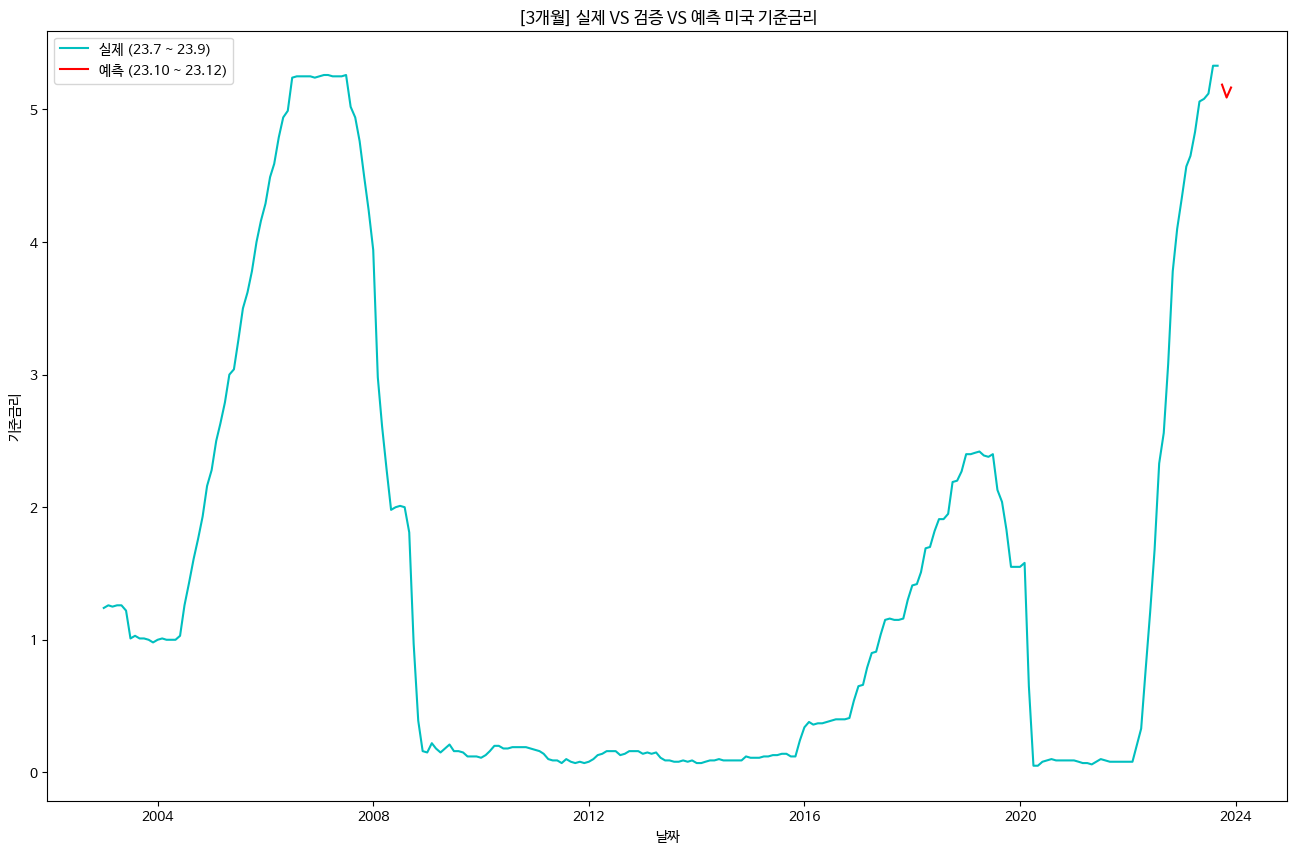

In [254]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_3['날짜'], for_plot_3['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[3개월] 실제 VS 검증 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 3개월 검증결과 큰 차이가 없음 (실제로 3.5 현행 유지중)
- 향후 3개월간 유지 예측 (10월 ~ 12월)

### 6개월 단위 예측 [MSE : 0.3936]

#### Validation

- train test split

In [255]:
train = eco_df_for_ts.iloc[: 243, :]
test = eco_df_for_ts.iloc[243 :, :]

train.shape, test.shape

((243, 23), (6, 23))

In [256]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2022-11-01  0.876498     0.524590 -1.262255  0.578947  0.553066   
        2022-12-01  0.833569     0.639344 -1.802575  0.578947  0.582452   
        2023-01-01  0.817376     0.688525 -0.709320  0.631579  0.589641   
        2023-02-01  0.882527     0.639344 -0.321424  0.631579  0.622622   
        2023-03-01  0.836373     0.557377 -0.669374  0.631579  0.622622   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2022-11-01  0.789241   0.888915    0.460317  1.784541 -0.514372  ...   
        2022-12-01  0.728579   0.844526    0.346032  1.273692 -0.746074  ...   
        2023-01-01  0.703314   0.818653    0.222222  0.966994 -0.935648  ...   
        2023-02-01  0.765620   0.815081    0.136508  1.820291 -0.914584  ...   
        2023-03-01  0.740909   0.827757    0.101587  1.625548 -0.914584  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2022-11-01   0.479969  0.017699        0.669836         1.000000   
        2022-12-01  -0.199078  0.008850        0.688388         0.975610   
        2023-01-01  -0.684112  0.000000        0.709906         0.951220   
        2023-02-01  -0.393092  0.017699        0.766641         0.926829   
        2023-03-01   0.091942  0.008850        0.801662         0.902439   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2022-11-01   0.061568  0.834954  1.940118           0.803399   
        2022-12-01  -0.446059  0.771566  1.718496           0.818967   
        2023-01-01  -0.852160  0.762588  1.512746           0.894240   
        2023-02-01  -1.055211  0.729470  1.558476           0.912887   
        2023-03-01  -1.359787  0.637701  1.600073           0.945049   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

- AutoGluon 자동화 시계열 예측 모델 학습

In [257]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality", excluded_model_types= ['SeasonalNaive', 'CrostonSBA'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_052258'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.48 GB / 12.68 GB (82.7%)
Disk Space Avail:   191.53 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'excluded_model_types': ['SeasonalNaive', 'CrostonSBA'],
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 243 rows, 1 time series. Median ti

- 전체 데이터를 대상으로 다시 학습

In [258]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['NPTS_FULL', 'AutoETS_FULL', 'DynamicOptimizedTheta_FULL', 'AutoARIMA_FULL', 'RecursiveTabular_FULL', 'DirectTabular_FULL', 'WeightedEnsemble_FULL']
Total runtime: 0.07 s
Updated best model t

{'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [259]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: AutoARIMA_FULL


done


In [260]:
# 원래값
test['미_금리']

243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [261]:
# 예측값
valid_6 = pred.reset_index()['mean']
pred.reset_index()['mean']

0    4.672632
1    4.692731
2    4.707349
3    4.717979
4    4.725711
5    4.731333
Name: mean, dtype: float64

In [262]:
round(mean_squared_error(test['미_금리'], pred.reset_index()['mean']), 4)

0.1973

In [263]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[243:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[243: , :]

<ipython-input-264-da506495e738>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


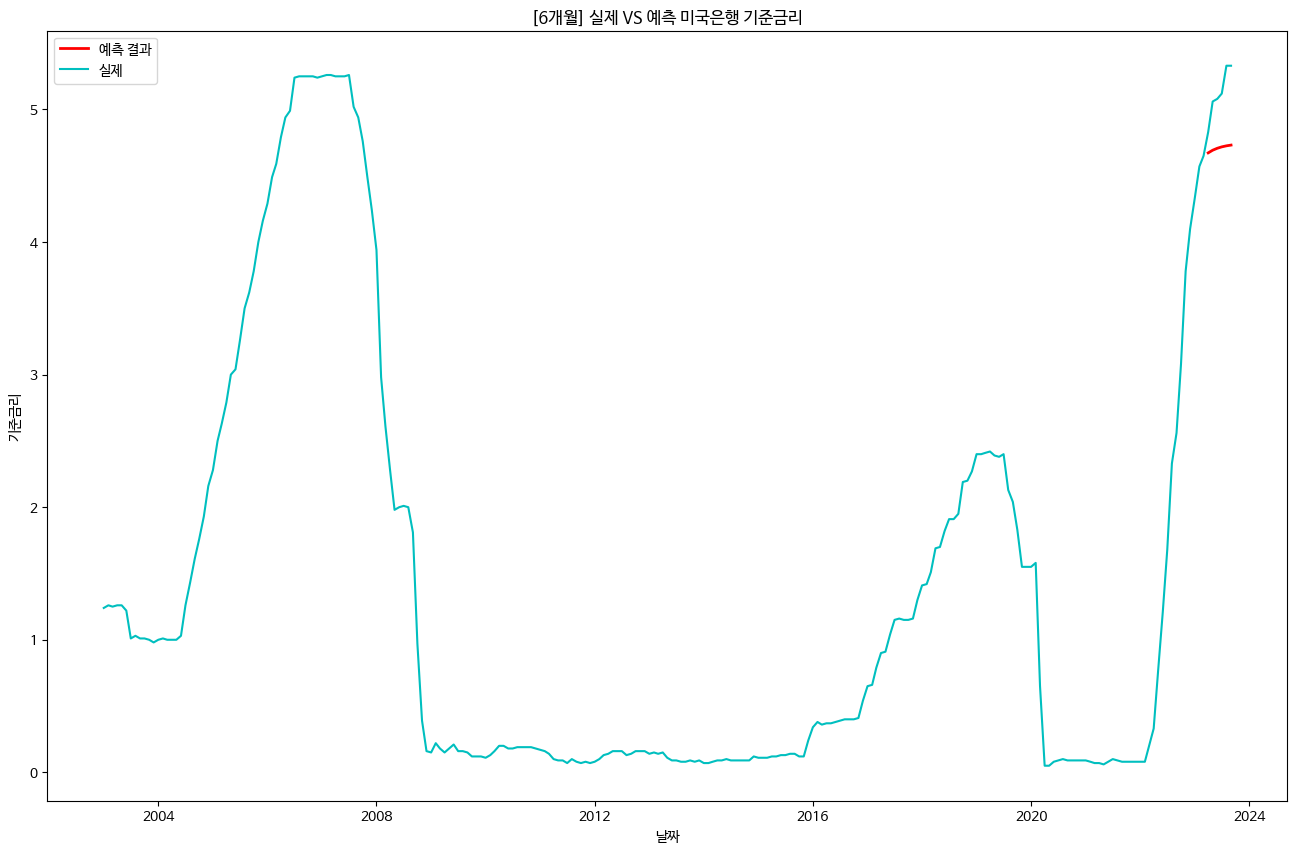

In [264]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('[6개월] 실제 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [265]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality",excluded_model_types= ['SeasonalNaive', 'CrostonSBA'] )

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_052415'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.68 GB (82.2%)
Disk Space Avail:   191.53 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'excluded_model_types': ['SeasonalNaive', 'CrostonSBA'],
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median ti

In [266]:
pred_6 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: AutoARIMA


In [267]:
for_plot_6 = pred_6.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [268]:
for_plot_6

,날짜,mean
0,2023-10-01,5.305210
1,2023-11-01,5.312326
2,2023-12-01,5.317488
3,2024-01-01,5.321232
4,2024-02-01,5.323948
5,2024-03-01,5.325918


<ipython-input-269-39ae6004906e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


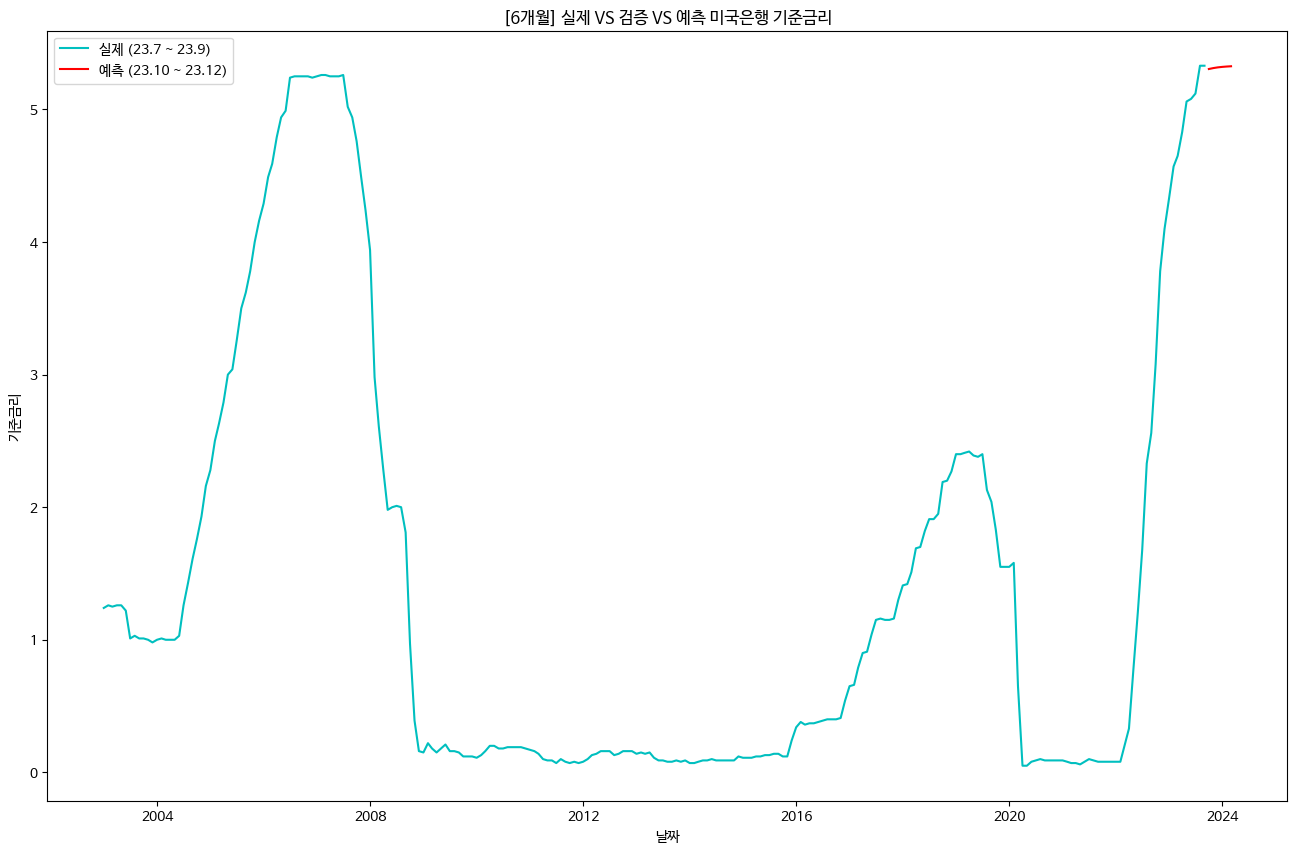

In [269]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_6['날짜'] = pd.to_datetime(for_plot_6['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_6['날짜'], for_plot_6['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[6개월] 실제 VS 검증 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 6개월 검증결과 큰 차이가 없음
- 향후 6개월간 유지 예측 (10월 ~ 03월)

### 12개월 단위 예측 [MSE : 0.6921]

#### Validation

- train test split

In [270]:
train = eco_df_for_ts.iloc[: 237, :]
test = eco_df_for_ts.iloc[237 :, :]

train.shape, test.shape

((237, 23), (12, 23))

In [271]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2022-05-01  0.499626     0.131148  0.279866  0.263158  0.216702   
        2022-06-01  0.575812     0.163934 -1.674328  0.263158  0.267442   
        2022-07-01  0.583383     0.213115 -0.962661  0.368421  0.315222   
        2022-08-01  0.626127     0.262295 -0.275171  0.421053  0.376956   
        2022-09-01  0.747301     0.311475 -1.513493  0.421053  0.434038   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2022-05-01  0.543185   0.897024    0.600000  1.016856  0.591479  ...   
        2022-06-01  0.608951   0.874502    0.657143  1.592620  0.559883  ...   
        2022-07-01  0.561769   0.875228    0.603175  1.599205  0.275521  ...   
        2022-08-01  0.575078   0.943305    0.533333  1.961410  0.012224  ...   
        2022-09-01  0.714493   1.000000    0.479365  2.832583 -0.145755  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2022-05-01   0.770990  0.017699        0.532154         0.756098   
        2022-06-01   0.770990  0.017699        0.549946         0.829268   
        2022-07-01   0.965003  0.008850        0.567052         0.902439   
        2022-08-01   1.256024  0.026549        0.562592         0.951220   
        2022-09-01   1.159017  0.008850        0.573400         0.975610   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2022-05-01   0.366143  0.960460  1.503286           1.401132   
        2022-06-01   0.467669  1.000000  1.528553           1.273682   
        2022-07-01   0.366143  0.952275  1.756344           1.079513   
        2022-08-01   0.264618  0.935215  1.721478           0.994660   
        2022-09-01   0.264618  0.934066  1.998820           0.914255   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

- AutoGluon 자동화 시계열 예측 모델 학습

In [272]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality", excluded_model_types= ['SeasonalNaive', 'CrostonSBA'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_052517'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.47 GB / 12.68 GB (82.6%)
Disk Space Avail:   191.52 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'excluded_model_types': ['SeasonalNaive', 'CrostonSBA'],
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 237 rows, 1 time series. Median t

- 전체 데이터를 대상으로 다시 학습

In [273]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['NPTS_FULL', 'AutoETS_FULL', 'DynamicOptimizedTheta_FULL', 'AutoARIMA_FULL', 'RecursiveTabular_FULL', 'DirectTabular_FULL', 'WeightedEnsemble_FULL']
Total runtime: 0.04 s
Updated best model t

{'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [274]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [275]:
# 원래값
test['미_금리']

237    3.08
238    3.78
239    4.10
240    4.33
241    4.57
242    4.65
243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [279]:
# 예측값
valid_12 = pred.reset_index()['0.9']

pred.reset_index()['0.9']

0     3.275307
1     3.563309
2     3.828068
3     4.022364
4     4.218995
5     4.425977
6     4.581940
7     4.778224
8     4.927163
9     5.086484
10    5.251381
11    5.424612
Name: 0.9, dtype: float64

In [280]:
round(mean_squared_error(test['미_금리'], pred.reset_index()['0.9']), 4)

0.0506

In [281]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[237:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[237: , :]

<ipython-input-282-8ede8322fda0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


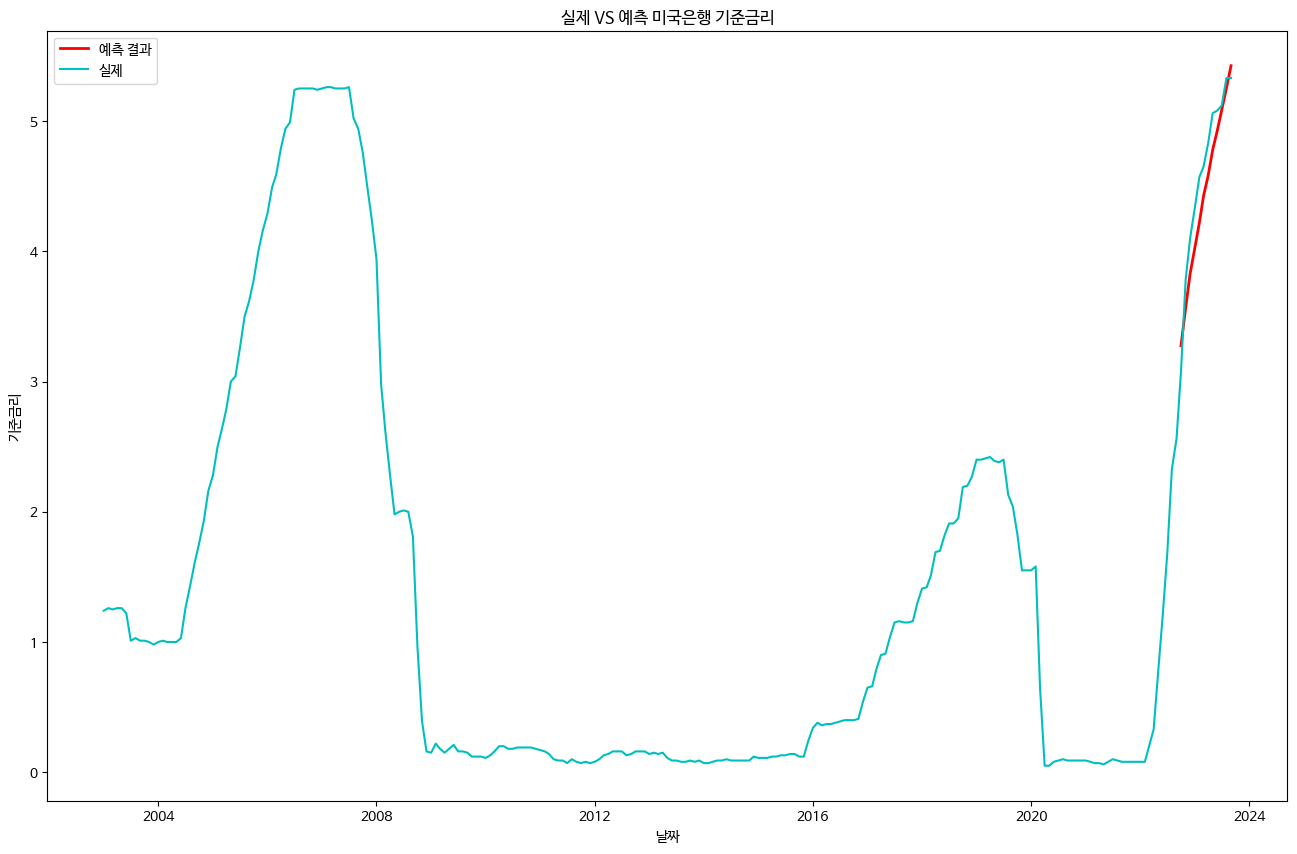

In [282]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [283]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality", excluded_model_types= ['SeasonalNaive', 'CrostonSBA'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_052712'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.35 GB / 12.68 GB (81.7%)
Disk Space Avail:   191.52 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'excluded_model_types': ['SeasonalNaive', 'CrostonSBA'],
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median t

In [284]:
pred_12 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [287]:
for_plot_12 = pred_12.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [289]:
for_plot_12

,날짜,mean
0,2023-10-01,5.440958
1,2023-11-01,5.833009
2,2023-12-01,6.013081
3,2024-01-01,6.142523
4,2024-02-01,6.277064
5,2024-03-01,6.322384
6,2024-04-01,6.424219
7,2024-05-01,6.296985
8,2024-06-01,6.229470
9,2024-07-01,6.251935


<ipython-input-292-3c8c3de6f6d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


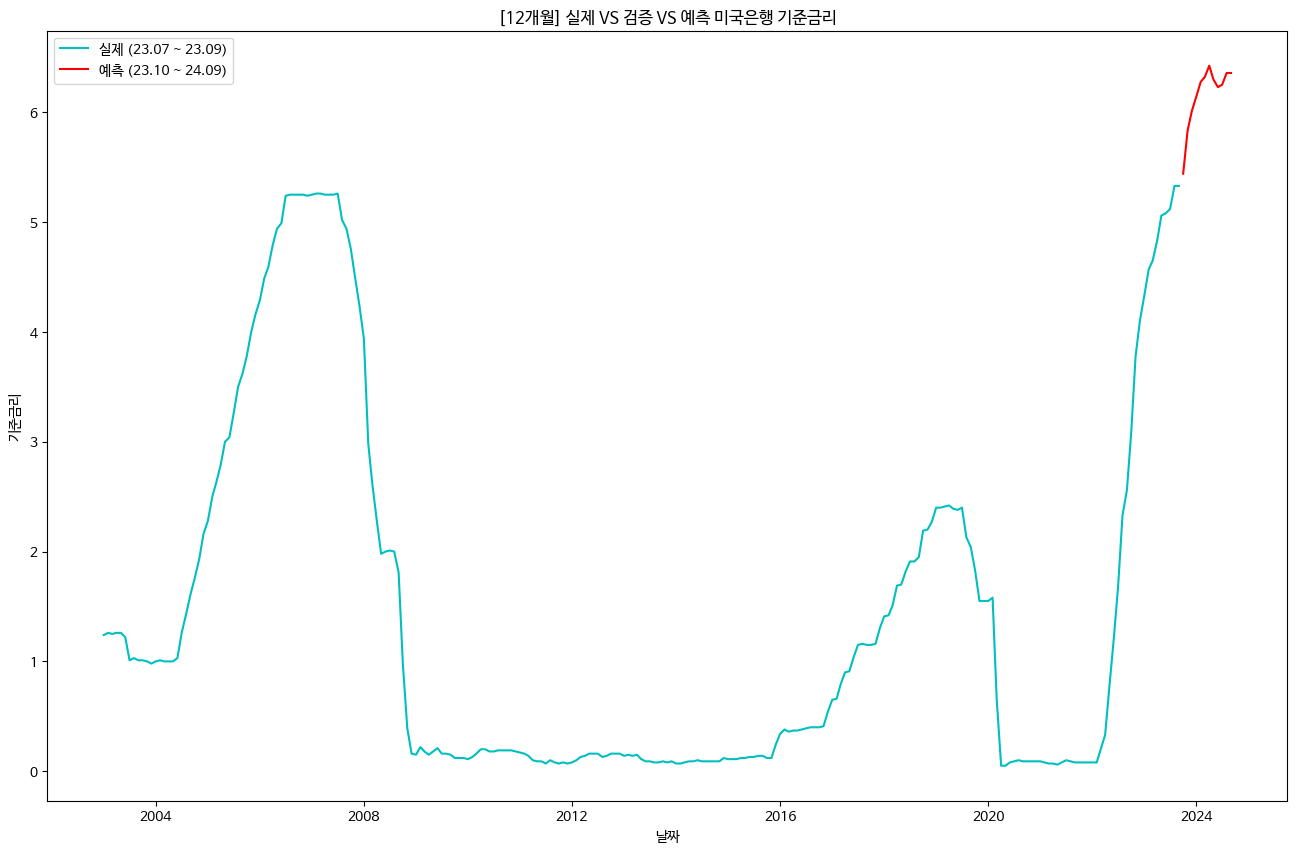

In [292]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_12['날짜'] = pd.to_datetime(for_plot_12['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.07 ~ 23.09)', c = 'c')
plt.plot(for_plot_12['날짜'], for_plot_12['mean'], label='예측 (23.10 ~ 24.09)', c = 'r')

plt.title('[12개월] 실제 VS 검증 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 12개 결과

### 18개월 단위 예측

- train test split

In [293]:
train = eco_df_for_ts.iloc[: 231, :]
test = eco_df_for_ts.iloc[231 :, :]

train.shape, test.shape

((231, 23), (18, 23))

In [294]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2021-11-01  0.078445     0.032787  1.077732  0.105263  0.066808   
        2021-12-01  0.112799     0.065574  1.150265  0.105263  0.112474   
        2022-01-01  0.172821     0.081967  0.288276  0.157895  0.149683   
        2022-02-01  0.263654     0.098361  0.327170  0.157895  0.156237   
        2022-03-01  0.358391     0.098361  0.326119  0.157895  0.161522   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2021-11-01  0.194941   0.724560    0.482540  0.553046  0.602011  ...   
        2021-12-01  0.200574   0.814532    0.476190  0.561513  0.602011  ...   
        2022-01-01  0.264932   0.904945    0.444444  0.718625  0.602011  ...   
        2022-02-01  0.321816   0.965493    0.431746  0.688519  0.580947  ...   
        2022-03-01  0.383798   0.968456    0.473016  0.780717  0.549351  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2021-11-01  -0.102071  0.070796        0.496226         0.609756   
        2021-12-01   0.576976  0.044248        0.553328         0.658537   
        2022-01-01   0.965003  0.053097        0.600921         0.609756   
        2022-02-01   1.159017  0.035398        0.614719         0.658537   
        2022-03-01   1.062010  0.017699        0.558573         0.707317   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2021-11-01   0.873770  0.809893  1.107723           2.008958   
        2021-12-01   0.772245  0.840381  1.176581           1.921539   
        2022-01-01   0.772245  0.877182  1.111799           1.850715   
        2022-02-01   0.569194  0.910194  1.108697           1.713684   
        2022-03-01   0.467669  0.961643  1.223579           1.548427   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [305]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")
#predictor.fit( data, random_seed=42, presets="best_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053025'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.35 GB / 12.68 GB (81.6%)
Disk Space Avail:   191.52 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 231 rows, 1 time series. Median time series length is 231 (min=231, max=231). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [306]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [307]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [308]:
# 원래값
test['미_금리']

231    0.33
232    0.77
233    1.21
234    1.68
235    2.33
236    2.56
237    3.08
238    3.78
239    4.10
240    4.33
241    4.57
242    4.65
243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [309]:
# 예측값
valid_18 = pred.reset_index()['0.9']

pred.reset_index()['0.9']

0     0.382830
1     0.386062
2     0.437105
3     0.463705
4     0.489813
5     0.574893
6     0.578355
7     0.577192
8     0.576213
9     0.494393
10    0.504234
11    0.526701
12    0.545333
13    0.536201
14    0.546184
15    0.556853
16    0.621759
17    0.703838
Name: 0.9, dtype: float64

In [310]:
round(mean_squared_error(test['미_금리'],pred.reset_index()['0.9']), 4)

11.6945

In [311]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[231:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[231: , :]

<ipython-input-313-d15060692e50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


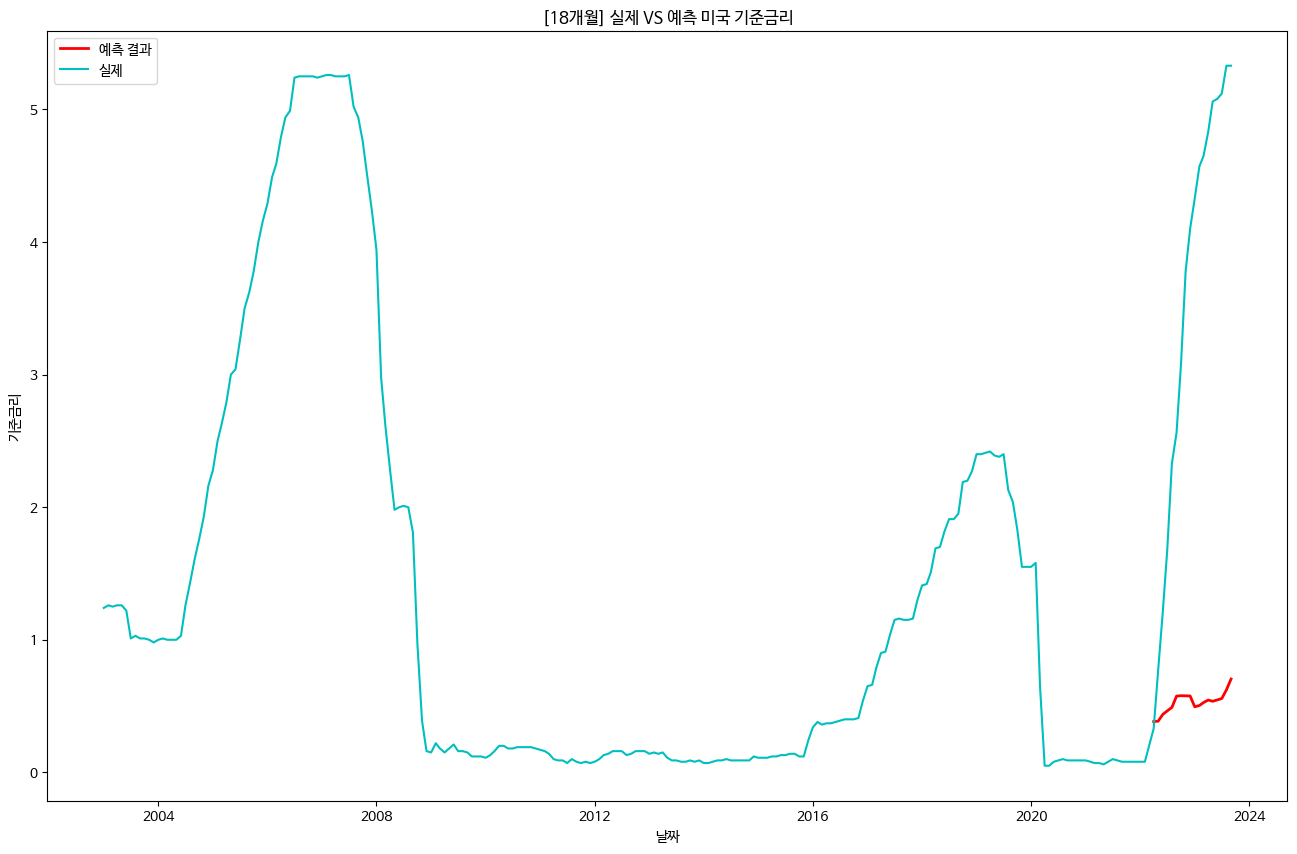

In [313]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [314]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")
#predictor.fit( eco_df_for_ts, random_seed=42, presets="high_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053125'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.42 GB / 12.68 GB (82.2%)
Disk Space Avail:   191.52 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [315]:
pred_18 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [316]:
pred_18

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  3.981044  3.338069  3.400498  3.453490  3.514298   
        2023-11-01  4.074464  3.465717  3.556149  3.635358  3.691076   
        2023-12-01  4.275834  3.502090  3.615893  3.722454  3.820572   
        2024-01-01  4.385997  3.514082  3.650980  3.764670  3.916861   
        2024-02-01  4.521171  3.539172  3.696814  3.822938  3.996253   
        2024-03-01  4.523995  3.519245  3.702971  3.833332  3.949749   
        2024-04-01  4.485361  3.537304  3.728354  3.869044  3.997786   
        2024-05-01  4.607309  3.559645  3.764019  3.928315  4.061766   
        2024-06-01  4.536202  3.452821  3.662696  3.832507  3.977160   
        2024-07-01  4.422859  3.366599  3.588286  3.766614  3.908045   
        2024-08-01  4.601039  3.399144  3.632052  3.811472  3.970317   
        2024-09-01  4.685626  3.364543  3.608161  3.802303  4.251247   
        2024-10-01  4.545565  3.363889  3.614267  3.805307  3.973572   
        2024-11-01  4.730732  3.552213  3.812452  4.010604  4.195445   
        2024-12-01  4.880894  3.623761  3.893506  4.098511  4.285708   
        2025-01-01  4.937696  3.664834  3.954263  4.169391  4.407746   
        2025-02-01  5.042216  3.713348  4.008170  4.219210  4.414045   
        2025-03-01  5.050580  3.723530  4.026979  4.258240  4.503891   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  3.821234  3.918171  4.192479  4.672471  4.976400  
        2023-11-01  3.757154  3.889732  4.214950  4.549658  5.287591  
        2023-12-01  3.991109  4.322646  4.480264  4.814324  5.589628  
        2024-01-01  4.308682  4.445004  4.576194  4.969884  5.764782  
        2024-02-01  4.391006  4.589758  4.969573  5.281197  5.988339  
        2024-03-01  4.202975  4.508702  5.017119  5.213980  6.087206  
        2024-04-01  4.161261  4.450737  4.838479  5.224169  6.234219  
        2024-05-01  4.372914  4.533562  4.929512  5.310809  6.439182  
        2024-06-01  4.386507  4.564855  4.905508  5.250319  6.370194  
        2024-07-01  4.324194  4.498844  4.818775  5.091603  5.747289  
        2024-08-01  4.441929  4.836540  5.054885  5.290305  6.569714  
        2024-09-01  4.669526  4.888305  5.218249  5.762391  6.573009  
        2024-10-01  4.401260  4.608448  5.000713  5.307254  6.114132  
        2024-11-01  4.422312  4.834678  5.264520  5.546671  6.359911  
        2024-12-01  4.567049  5.075890  5.455587  5.688592  6.598837  
        2025-01-01  4.799376  5.103506  5.324362  5.822989  6.763418  
        2025-02-01  4.754796  5.130546  5.706881  6.117421  6.961743  
        2025-03-01  4.776110  5.156829  5.745480  6.036240  7.018690

In [317]:
for_plot_18 = pred_18.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [318]:
for_plot_18

,날짜,mean
0,2023-10-01,3.981044
1,2023-11-01,4.074464
2,2023-12-01,4.275834
3,2024-01-01,4.385997
4,2024-02-01,4.521171
5,2024-03-01,4.523995
6,2024-04-01,4.485361
7,2024-05-01,4.607309
8,2024-06-01,4.536202
9,2024-07-01,4.422859


<ipython-input-319-b19a61f78722>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


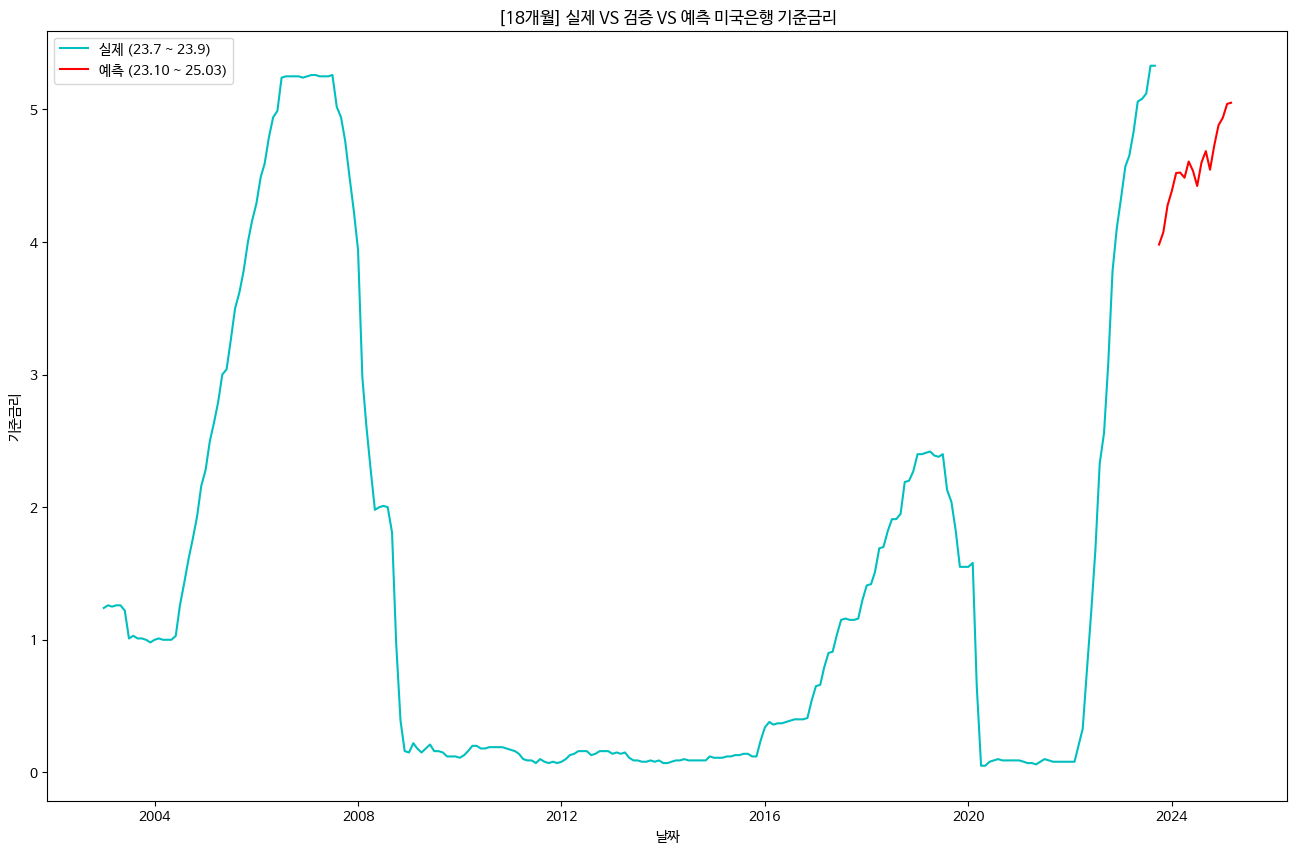

In [319]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_18['날짜'], for_plot_18['mean'], label='예측 (23.10 ~ 25.03)', c = 'r')

plt.title('[18개월] 실제 VS 검증 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 24개월 단위 예측

- train test split

In [320]:
train = eco_df_for_ts.iloc[: 225, :]
test = eco_df_for_ts.iloc[225 :, :]

train.shape, test.shape

((225, 23), (24, 23))

In [321]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2021-05-01  0.007937     0.000000  1.577055  0.000000  0.000000   
        2021-06-01  0.017470     0.000000  1.879803  0.000000  0.006342   
        2021-07-01  0.020825     0.000000  1.762068  0.000000  0.010571   
        2021-08-01  0.020375     0.000000  0.971560  0.052632  0.016913   
        2021-09-01  0.025105     0.000000  0.617303  0.052632  0.061311   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2021-05-01  0.115159   0.528594    0.431746 -0.171364  0.444032  ...   
        2021-06-01  0.119145   0.630041    0.444444 -0.028364  0.728393  ...   
        2021-07-01  0.103658   0.591913    0.450794  0.199308  0.675734  ...   
        2021-08-01  0.105321   0.553145    0.444444  0.285861  0.675734  ...   
        2021-09-01  0.124389   0.566103    0.425397  0.516355  0.496692  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2021-05-01  -0.199078  0.212389        0.544677         0.390244   
        2021-06-01  -0.393092  0.221239        0.501863         0.414634   
        2021-07-01  -0.490099  0.176991        0.479634         0.439024   
        2021-08-01  -0.587105  0.159292        0.478997         0.439024   
        2021-09-01  -0.587105  0.123894        0.491594         0.463415   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2021-05-01   1.990548  0.631101  0.787494           2.163438   
        2021-06-01   2.193599  0.664758  0.818217           2.292599   
        2021-07-01   2.092074  0.659239  0.943795           2.343579   
        2021-08-01   1.889023  0.656190  0.972652           2.351277   
        2021-09-01   1.482922  0.674124  0.975964           2.284216   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [322]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053229'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.68 GB (82.4%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 225 rows, 1 time series. Median time series length is 225 (min=225, max=225). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [323]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [324]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [325]:
# 원래값
test['미_금리']

225    0.08
226    0.08
227    0.08
228    0.08
229    0.08
230    0.20
231    0.33
232    0.77
233    1.21
234    1.68
235    2.33
236    2.56
237    3.08
238    3.78
239    4.10
240    4.33
241    4.57
242    4.65
243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [328]:
# 예측값
valid_24 = pred.reset_index()['mean']

pred.reset_index()['mean']

0     0.897213
1     0.790463
2     0.814691
3     0.869999
4     0.861991
5     0.962268
6     1.051143
7     1.057532
8     1.110923
9     1.070278
10    0.919882
11    1.088236
12    1.115556
13    1.024418
14    1.088952
15    1.151862
16    1.231428
17    1.297024
18    1.403014
19    1.250892
20    1.304464
21    1.303943
22    1.266348
23    1.313275
Name: mean, dtype: float64

In [329]:
pred

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2021-10-01  0.897213  0.048032  0.062865  0.092023  0.144240   
        2021-11-01  0.790463  0.083321  0.104300  0.137888  0.193890   
        2021-12-01  0.814691  0.073322  0.117477  0.160619  0.225680   
        2022-01-01  0.869999  0.140867  0.188996  0.228850  0.265591   
        2022-02-01  0.861991  0.155643  0.201120  0.243499  0.282397   
        2022-03-01  0.962268  0.178020  0.238971  0.283633  0.330636   
        2022-04-01  1.051143  0.203953  0.261661  0.302269  0.332603   
        2022-05-01  1.057532  0.190263  0.250681  0.299396  0.349862   
        2022-06-01  1.110923  0.262702  0.313357  0.370062  0.415942   
        2022-07-01  1.070278  0.266429  0.313338  0.371778  0.419141   
        2022-08-01  0.919882  0.253979  0.303177  0.344806  0.393580   
        2022-09-01  1.088236  0.231406  0.288946  0.356768  0.394582   
        2022-10-01  1.115556  0.228737  0.282221  0.363864  0.415279   
        2022-11-01  1.024418  0.264025  0.325682  0.365704  0.418363   
        2022-12-01  1.088952  0.263992  0.339904  0.405946  0.441344   
        2023-01-01  1.151862  0.366890  0.438533  0.499780  0.554800   
        2023-02-01  1.231428  0.366613  0.446236  0.514953  0.595714   
        2023-03-01  1.297024  0.377444  0.458840  0.522682  0.586073   
        2023-04-01  1.403014  0.379210  0.462331  0.539724  0.714947   
        2023-05-01  1.250892  0.381025  0.465826  0.525969  0.597611   
        2023-06-01  1.304464  0.451610  0.525741  0.580911  0.659717   
        2023-07-01  1.303943  0.456152  0.525729  0.582053  0.643383   
        2023-08-01  1.266348  0.445571  0.522866  0.574163  0.654918   
        2023-09-01  1.313275  0.424410  0.497081  0.555635  0.631179   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2021-10-01  0.632782  0.752094  1.179695  1.411930  3.008302  
        2021-11-01  0.341356  0.716514  1.067900  1.316873  2.611698  
        2021-12-01  0.425091  0.710656  1.077256  1.471167  2.727629  
        2022-01-01  0.578061  0.810530  1.081117  1.637894  1.741408  
        2022-02-01  0.436884  0.843678  1.214884  1.743417  1.838125  
        2022-03-01  0.462330  0.661716  0.899488  1.793381  3.171255  
        2022-04-01  0.385974  0.839345  1.349680  1.827210  3.324918  
        2022-05-01  0.503255  0.859724  1.371729  1.826598  3.437785  
        2022-06-01  0.576954  1.008735  1.146923  1.659012  3.543514  
        2022-07-01  0.587693  0.614707  1.111301  1.674357  2.490496  
        2022-08-01  0.440374  0.616399  1.114404  1.611418  1.796001  
        2022-09-01  0.578020  1.069151  1.593119  1.685557  2.709250  
        2022-10-01  0.926079  0.981495  1.100602  1.557629  2.811114  
        2022-11-01  0.616480  0.660751  1.156486  1.836508  2.999704  
        2022-12-01  0.708275  1.209052  1.244450  1.439722  3.103327  
        2023-01-01  0.884354  1.133909  1.422775  1.551714  2.134126  
        2023-02-01  0.901705  1.306157  1.540764  2.089481  2.507566  
        2023-03-01  0.911547  1.033944  1.355797  2.115023  3.519496  
        2023-04-01  1.078337  1.601727  2.004642  2.137420  3.660541  
        2023-05-01  0.765046  1.135557  1.391815  2.135034  2.576758  
        2023-06-01  0.729633  0.873395  1.801432  2.195063  2.669195  
        2023-07-01  0.701913  0.883519  1.861772  1.973480  2.812288  
        2023-08-01  0.843579  1.272240  1.396072  1.908908  2.958510  
        2023-09-01  0.703798  1.250263  1.381191  1.925900  3.026263

In [330]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[225:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[225: , :]

<ipython-input-331-882a4fdaae39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


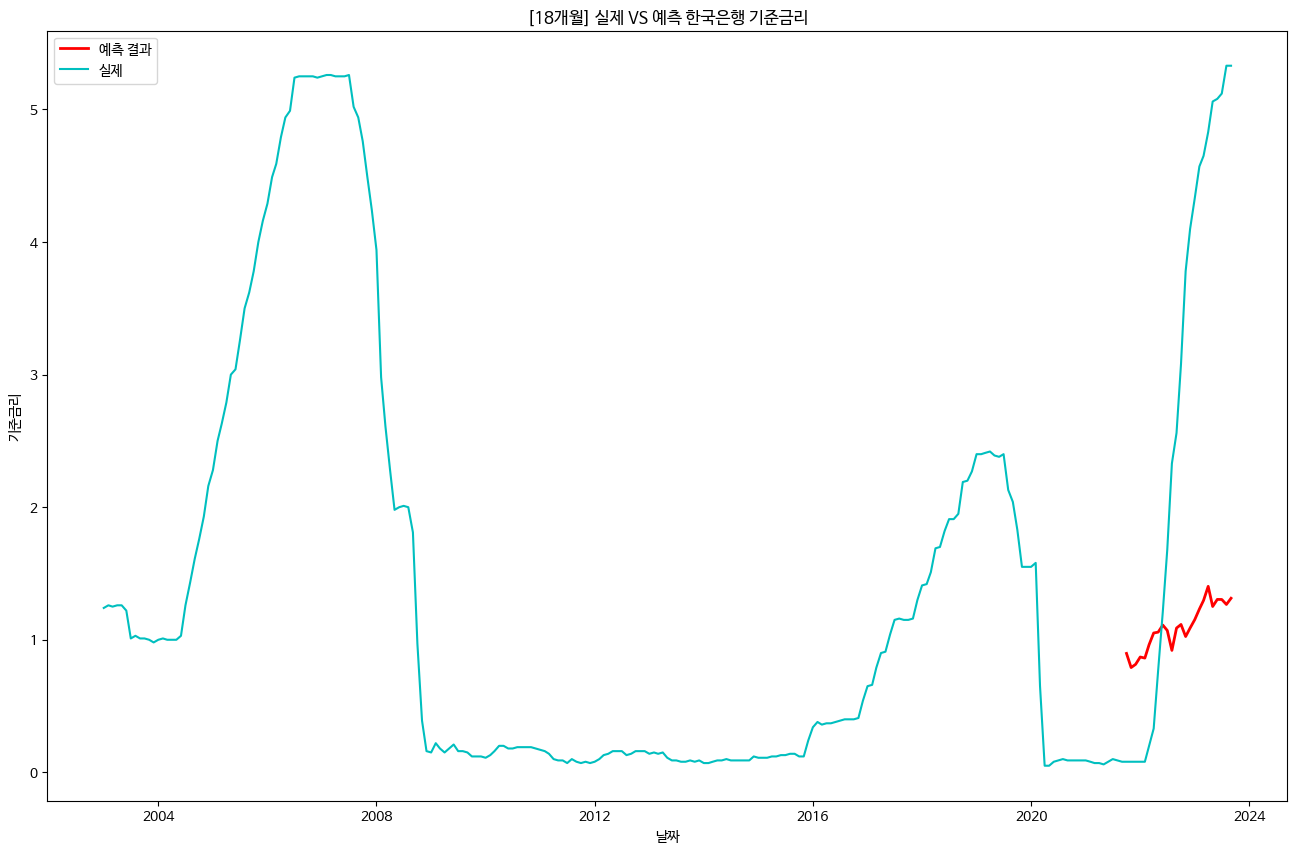

In [331]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [332]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053345'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.38 GB / 12.68 GB (81.9%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [333]:
pred_24 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


In [334]:
pred_24

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  5.709195  4.961838  5.218390  5.403383  5.561452   
        2023-11-01  6.383365  5.326442  5.689262  5.950881  6.174424   
        2023-12-01  6.690510  5.396049  5.840411  6.160827  6.434611   
        2024-01-01  6.895930  5.401216  5.914320  6.284305  6.600443   
        2024-02-01  7.098322  5.427181  6.000850  6.414505  6.767958   
        2024-03-01  7.081927  5.251284  5.879706  6.332843  6.720031   
        2024-04-01  7.175834  5.198513  5.877286  6.366730  6.784941   
        2024-05-01  7.277965  5.164120  5.889759  6.412997  6.860084   
        2024-06-01  7.205182  4.963111  5.732768  6.287745  6.761952   
        2024-07-01  7.200873  4.837523  5.648812  6.233809  6.733668   
        2024-08-01  7.128912  4.650209  5.501097  6.114647  6.638903   
        2024-09-01  7.118081  4.529160  5.417883  6.058716  6.606283   
        2024-10-01  7.294674  4.600039  5.525052  6.192051  6.761978   
        2024-11-01  7.633167  4.836813  5.796744  6.488922  7.080362   
        2024-12-01  7.746164  4.851663  5.845286  6.561758  7.173957   
        2025-01-01  7.775181  4.785752  5.811962  6.551931  7.184207   
        2025-02-01  7.856205  4.774773  5.832565  6.595308  7.247044   
        2025-03-01  7.608019  4.437251  5.525711  6.310567  6.981197   
        2025-04-01  7.393241  4.135587  5.253872  6.060235  6.749242   
        2025-05-01  7.096120  3.753838  4.901175  5.728485  6.435392   
        2025-06-01  6.699028  3.274207  4.449878  5.297619  6.021983   
        2025-07-01  5.798173  2.292757  3.496094  4.363785  5.105195   
        2025-08-01  4.885079  1.300880  2.531262  3.418454  4.176527   
        2025-09-01  4.417750  0.756463  2.013307  2.919581  3.693958   

                         0.5       0.6       0.7       0.8        0.9  
item_id timestamp                                                      
0       2023-10-01  5.709195  5.856939  6.015008  6.200000   6.456552  
        2023-11-01  6.383365  6.592305  6.815849  7.077467   7.440287  
        2023-12-01  6.690510  6.946409  7.220193  7.540609   7.984970  
        2024-01-01  6.895930  7.191417  7.507555  7.877539   8.390644  
        2024-02-01  7.098322  7.428687  7.782140  8.195795   8.769464  
        2024-03-01  7.081927  7.443823  7.831012  8.284149   8.912571  
        2024-04-01  7.175834  7.566726  7.984937  8.474381   9.153155  
        2024-05-01  7.277965  7.695846  8.142933  8.666171   9.391810  
        2024-06-01  7.205182  7.648412  8.122620  8.677596   9.447254  
        2024-07-01  7.200873  7.668079  8.167937  8.752934   9.564224  
        2024-08-01  7.128912  7.618921  8.143177  8.756727   9.607615  
        2024-09-01  7.118081  7.629879  8.177447  8.818279   9.707002  
        2024-10-01  7.294674  7.827370  8.397297  9.064296   9.989308  
        2024-11-01  7.633167  8.185972  8.777413  9.469591  10.429522  
        2024-12-01  7.746164  8.318372  8.930571  9.647043  10.640666  
        2025-01-01  7.775181  8.366154  8.998431  9.738400  10.764609  
        2025-02-01  7.856205  8.465367  9.117103  9.879845  10.937638  
        2025-03-01  7.608019  8.234841  8.905472  9.690328  10.778787  
        2025-04-01  7.393241  8.037239  8.726247  9.532609  10.650895  
        2025-05-01  7.096120  7.756849  8.463755  9.291066  10.438403  
        2025-06-01  6.699028  7.376073  8.100437  8.948178  10.123849  
        2025-07-01  5.798173  6.491151  7.232561  8.100251   9.303589  
        2025-08-01  4.885079  5.593631  6.351704  7.238896   8.469278  
        2025-09-01  4.417750  5.141542  5.915919  6.822192   8.079037

In [335]:
for_plot_24 = pred_24.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-336-e84e833f41c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


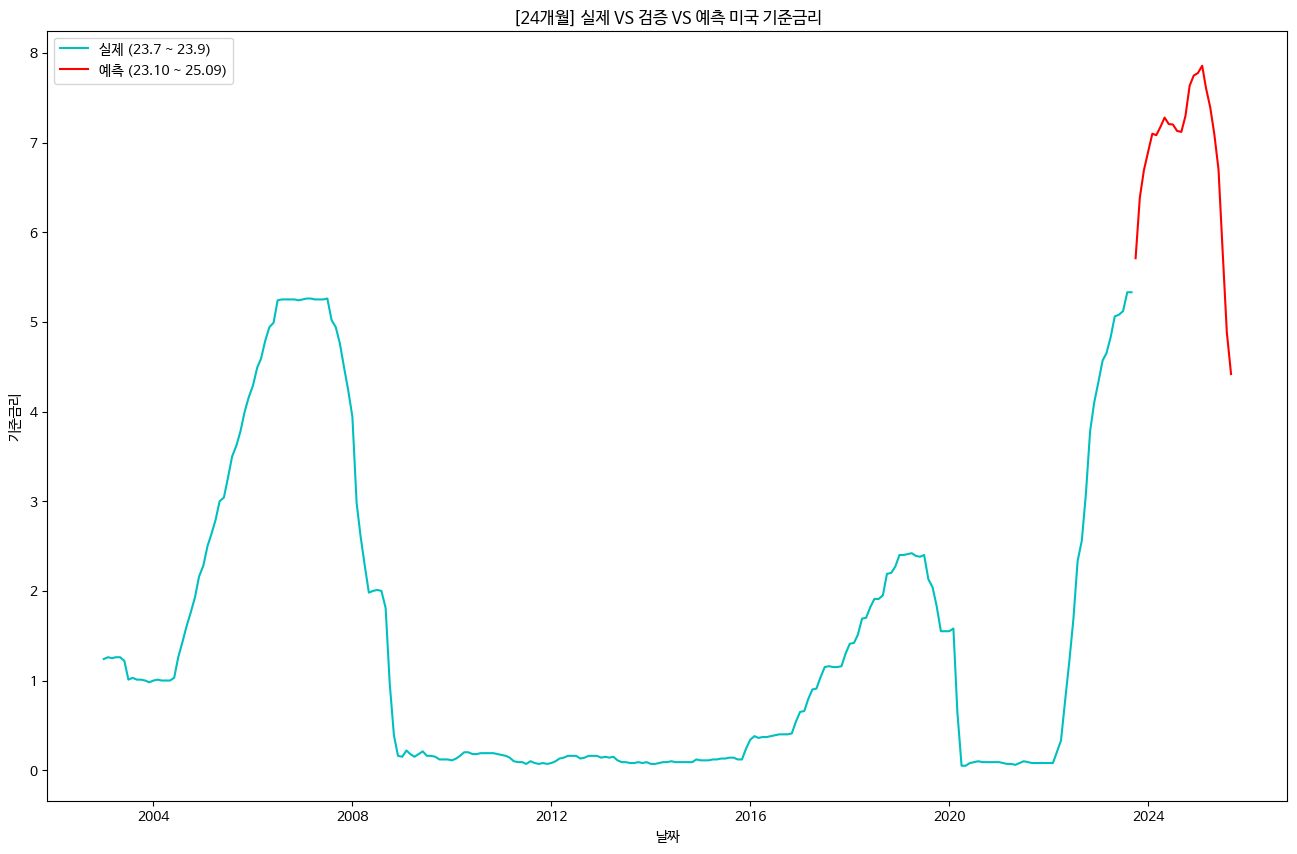

In [336]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_24['날짜'] = pd.to_datetime(for_plot_24['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_24['날짜'], for_plot_24['mean'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[24개월] 실제 VS 검증 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 30개월 단위 예측

- train test split

In [337]:
train = eco_df_for_ts.iloc[: 219, :]
test = eco_df_for_ts.iloc[219 :, :]

train.shape, test.shape

((219, 23), (30, 23))

In [338]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2020-11-01  0.010092     0.016393  1.275359  0.000000  0.002114   
        2020-12-01  0.004124     0.016393  1.346841  0.000000  0.006342   
        2021-01-01  0.003154     0.016393  1.416221  0.000000  0.002114   
        2021-02-01  0.000000     0.000000  0.694041  0.000000  0.002114   
        2021-03-01  0.006330     0.000000  1.422528  0.000000  0.002114   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2020-11-01  0.025253   0.175661    0.314286 -0.212759 -1.493839  ...   
        2020-12-01  0.024839   0.170598    0.323810 -0.402798 -1.198946  ...   
        2021-01-01  0.037203   0.133500    0.339683 -0.097041 -1.051499  ...   
        2021-02-01  0.057485   0.113539    0.342857 -0.052824 -0.882988  ...   
        2021-03-01  0.115897   0.175183    0.371429  0.025262 -0.324797  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2020-11-01  -1.363160  0.292035        0.669003         0.024390   
        2020-12-01  -1.363160  0.292035        0.661087         0.024390   
        2021-01-01  -1.654180  0.256637        0.634154         0.170732   
        2021-02-01  -1.557173  0.247788        0.606607         0.219512   
        2021-03-01  -1.072139  0.238938        0.585286         0.292683   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2020-11-01   0.163093  0.287036  1.031235           0.946931   
        2020-12-01   0.467669  0.301219  0.844778           1.166076   
        2021-01-01   0.772245  0.307898  0.809978           1.583155   
        2021-02-01   0.975295  0.335311  0.855224           1.918631   
        2021-03-01   1.279871  0.421354  0.967543           2.076361   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [339]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053436'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.39 GB / 12.68 GB (81.9%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 219 rows, 1 time series. Median time series length is 219 (min=219, max=219). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [340]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [341]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [343]:
# 원래값
test['미_금리']

219    0.07
220    0.06
221    0.08
222    0.10
223    0.09
224    0.08
225    0.08
226    0.08
227    0.08
228    0.08
229    0.08
230    0.20
231    0.33
232    0.77
233    1.21
234    1.68
235    2.33
236    2.56
237    3.08
238    3.78
239    4.10
240    4.33
241    4.57
242    4.65
243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [345]:
# 예측값
valid_30 = pred.reset_index()['mean']

pred.reset_index()['mean']

0     0.933638
1     0.916571
2     0.889419
3     0.861296
4     0.938486
5     1.063949
6     1.079269
7     0.990087
8     0.970864
9     0.924436
10    0.798039
11    0.900128
12    0.857392
13    0.731783
14    0.852473
15    0.871260
16    1.011640
17    1.025874
18    1.134092
19    0.915667
20    0.811003
21    0.914922
22    0.766436
23    0.798328
24    0.581389
25    0.870828
26    0.708601
27    0.830816
28    0.759155
29    0.841272
Name: mean, dtype: float64

In [346]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[219:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[219: , :]

<ipython-input-347-7dc391bacf61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


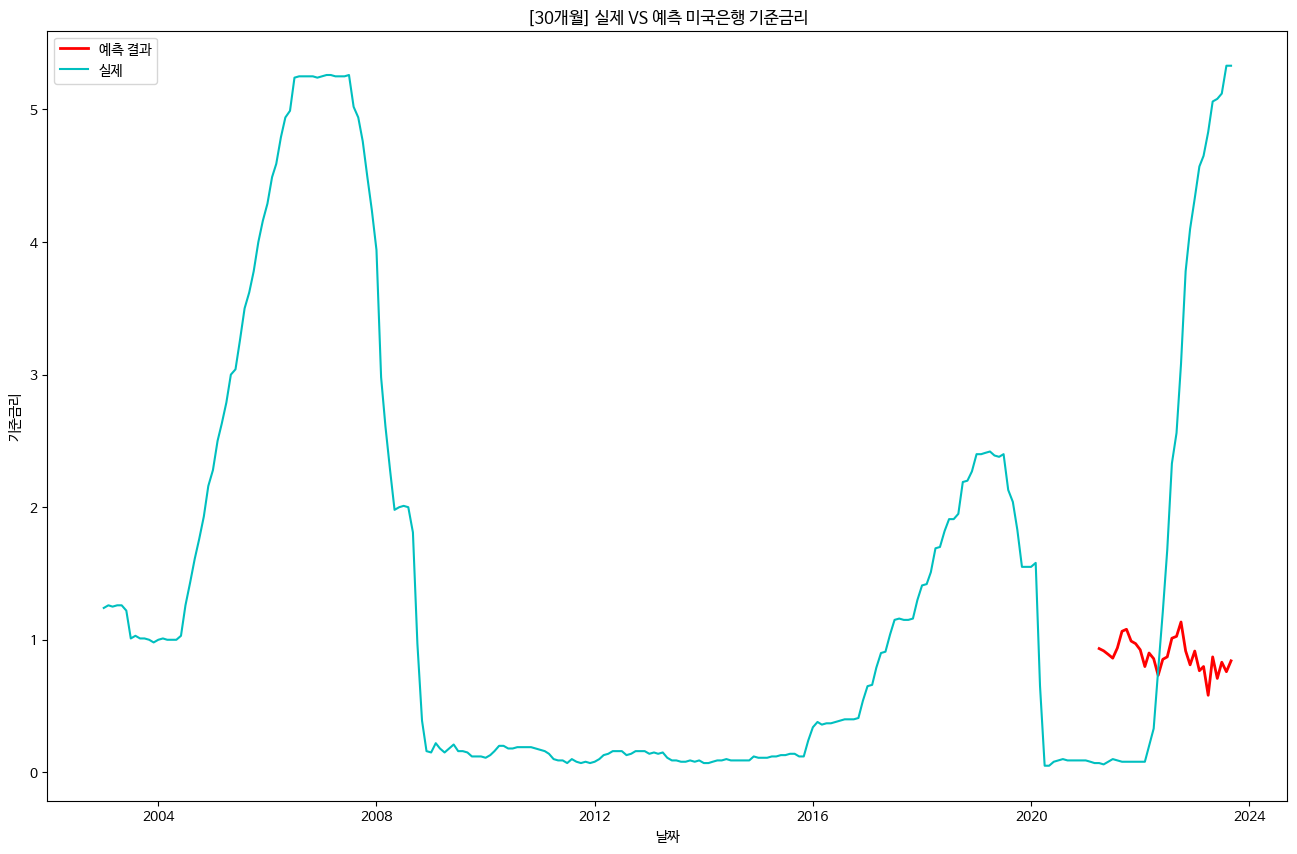

In [347]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('[30개월] 실제 VS 예측 미국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [348]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="미_금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053606'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.38 GB / 12.68 GB (81.9%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [349]:
pred_30 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [350]:
pred_30

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  1.395288  0.064650  0.126820  0.192040  0.287464   
        2023-11-01  1.139124  0.000429  0.075698  0.165761  0.212136   
        2023-12-01  1.353772 -0.039902  0.079125  0.181386  0.309763   
        2024-01-01  1.474293 -0.090393  0.042895  0.146492  0.391024   
        2024-02-01  1.594993 -0.126994  0.018859  0.140463  0.419578   
        2024-03-01  1.547393 -0.160083  0.015023  0.135870  0.251984   
        2024-04-01  1.313598 -0.181565 -0.013908  0.114472  0.245969   
        2024-05-01  1.458338 -0.230584 -0.035310  0.117975  0.246515   
        2024-06-01  1.472614 -0.215084 -0.046467  0.122350  0.265463   
        2024-07-01  1.346098 -0.240244 -0.062990  0.112055  0.233647   
        2024-08-01  1.618098 -0.264174 -0.078706  0.084368  0.237864   
        2024-09-01  1.843214 -0.295987 -0.102669  0.083959  0.967028   
        2024-10-01  1.370882 -0.308970 -0.117072  0.048143  0.202166   
        2024-11-01  1.325251 -0.330072 -0.104088  0.075297  0.224837   
        2024-12-01  1.465277 -0.350434 -0.144302  0.031176  0.211864   
        2025-01-01  1.394682 -0.379074 -0.139340  0.041013  0.351129   
        2025-02-01  1.521914 -0.398161 -0.160822  0.024255  0.239987   
        2025-03-01  1.506614 -0.389852 -0.146151  0.061409  0.361587   
        2025-04-01  1.349229 -0.443666 -0.184830  0.018243  0.170129   
        2025-05-01  1.395398 -0.470170 -0.205307 -0.006835  0.175605   
        2025-06-01  1.357640 -0.469398 -0.207605  0.021948  0.190115   
        2025-07-01  1.550545 -0.477171 -0.218585  0.015106  0.186810   
        2025-08-01  1.723766 -0.484567 -0.202476  0.008418  0.380421   
        2025-09-01  1.687798 -0.518454 -0.248768 -0.016021  0.377259   
        2025-10-01  1.078768 -0.552710 -0.277647 -0.058917  0.140834   
        2025-11-01  1.604158 -0.568062 -0.287729 -0.092041  0.164641   
        2025-12-01  1.134421 -0.583122 -0.297619 -0.071361  0.134822   
        2026-01-01  1.318916 -0.597905 -0.307328 -0.059516  0.140846   
        2026-02-01  1.117063 -0.612427 -0.307917 -0.074405  0.120081   
        2026-03-01  1.227653 -0.635648 -0.335185 -0.080246  0.126207   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  1.016009  1.207711  1.848925  2.209407  3.685262  
        2023-11-01  0.291272  0.558302  1.275730  2.018951  3.749483  
        2023-12-01  0.631272  1.364359  1.644841  2.355524  4.138761  
        2024-01-01  1.257588  1.470993  1.661841  2.499122  4.296621  
        2024-02-01  1.275482  1.487176  2.437344  3.042106  4.583748  
        2024-03-01  0.729693  1.117928  1.654568  4.504363  4.688416  
        2024-04-01  0.443377  1.034470  1.828072  2.582767  4.844108  
        2024-05-01  0.843207  1.055161  1.854754  2.580670  5.120155  
        2024-06-01  1.100045  1.344101  1.988267  2.604452  5.099385  
        2024-07-01  1.073203  1.295390  1.873299  2.289923  3.576650  
        2024-08-01  1.207414  1.980121  2.285723  2.591954  5.452686  
        2024-09-01  1.788993  2.100957  2.679816  3.761181  5.403972  
        2024-10-01  1.037414  1.308977  2.035632  2.496110  4.110640  
        2024-11-01  0.536361  1.671043  2.133741  2.518915  4.131742  
        2024-12-01  0.652677  1.675068  2.347862  2.594918  4.438419  
        2025-01-01  1.064256  1.553698  1.810130  2.724167  4.628112  
        2025-02-01  0.760045  1.566419  2.578467  3.255649  4.897725  
        2025-03-01  0.751098  1.417977  2.594998  2.954662  4.987837  
        2025-04-01  0.464782  1.108383  1.958163  2.778605  5.131125  
        2025-05-01  0.858466  1.120801  1.974294  2.763293  5.282892  
        2025-06-01  0.509519  1.240502  1.551827  2.765590  5.344752  
        2025-07-01  1.198466  1.816439  2.265511  2.794465  5.477788  
        2025-08

In [351]:
for_plot_30 = pred_30.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-352-f75e22eba901>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


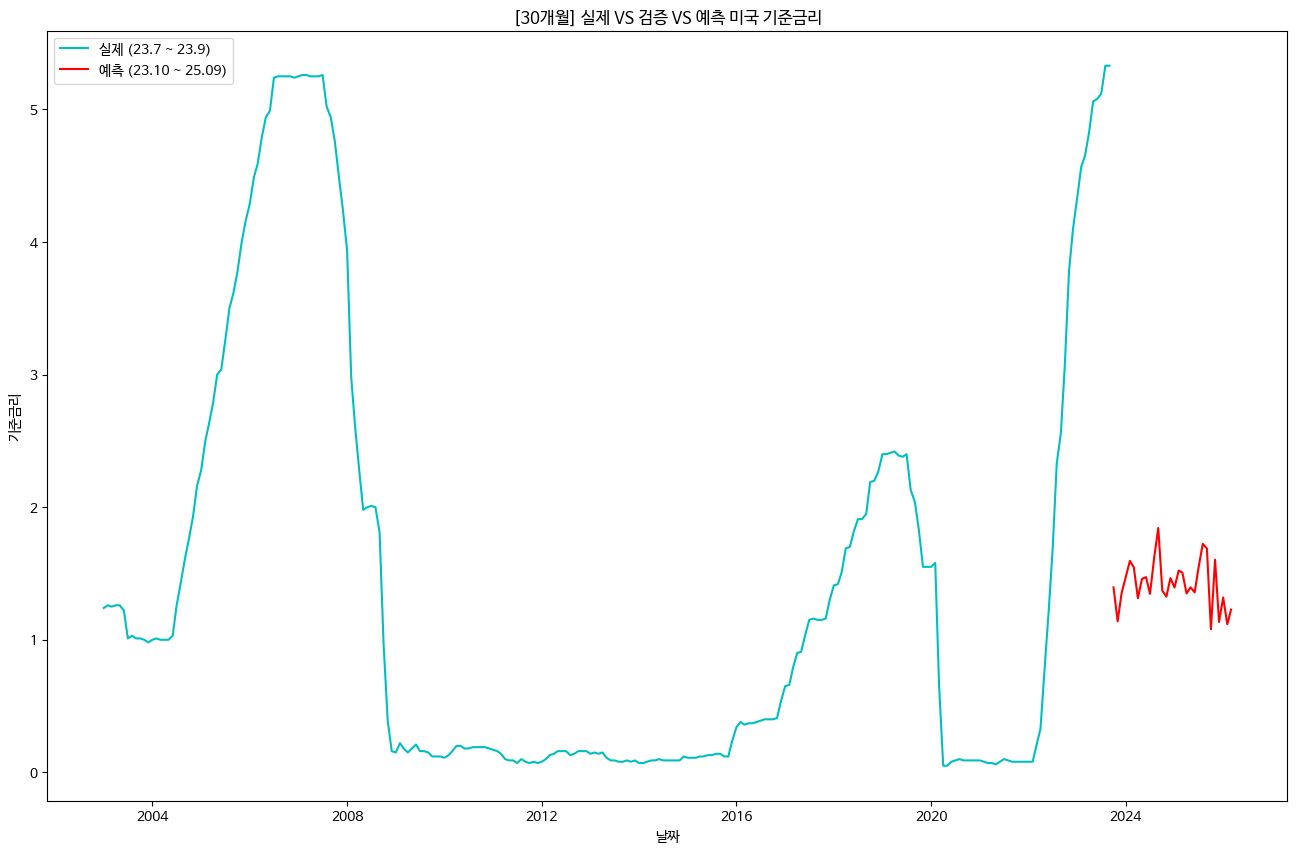

In [352]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_30['날짜'] = pd.to_datetime(for_plot_30['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_30['날짜'], for_plot_30['mean'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[30개월] 실제 VS 검증 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 36개월 단위 예측

- train test split

In [353]:
train = eco_df_for_ts.iloc[: 213, :]
test = eco_df_for_ts.iloc[213 :, :]

train.shape, test.shape

((213, 23), (36, 23))

In [354]:
data = TimeSeriesDataFrame(train)
data

미국채_2  CP유통수익률(%p)    뉴스심리지수      기준금리       콜금리  \
item_id timestamp                                                         
0       2003-01-01  0.325188     0.590164  0.615201  0.789474  0.803383   
        2003-02-01  0.302130     0.606557  0.615201  0.789474  0.807611   
        2003-03-01  0.291327     0.622951  0.615201  0.789474  0.794926   
        2003-04-01  0.301029     0.655738  0.615201  0.789474  0.794926   
        2003-05-01  0.259655     0.672131  0.615201  0.736842  0.758985   
...                      ...          ...       ...       ...       ...   
        2020-05-01  0.011033     0.147541 -1.069884  0.000000  0.046512   
        2020-06-01  0.013929     0.147541 -0.178460  0.000000  0.000000   
        2020-07-01  0.006575     0.114754  0.576306  0.000000  0.000000   
        2020-08-01  0.004846     0.081967 -0.112234  0.000000  0.004228   
        2020-09-01  0.003895     0.065574 -0.120644  0.000000  0.000000   

                       미국채_5  미_coremom  장단기금리차(%p)     원달러환율    경제심리지수  ...  \
item_id timestamp                                                        ...   
0       2003-01-01  0.580284   0.224837    0.393651 -0.555207  0.170202  ...   
        2003-02-01  0.548103   0.197885    0.346032  0.607611  0.033288  ...   
        2003-03-01  0.524339   0.188977    0.307937  1.180553 -0.135223  ...   
        2003-04-01  0.554493   0.144580    0.273016  0.810822 -0.240542  ...   
        2003-05-01  0.468492   0.152907    0.247619  0.722388 -0.451180  ...   
...                      ...        ...         ...       ...       ...  ...   
        2020-05-01  0.015172   0.106606    0.209524  1.029086 -3.716071  ...   
        2020-06-01  0.016223   0.095022    0.247619  0.695105 -3.737135  ...   
        2020-07-01  0.002493   0.154166    0.257143  0.585032 -3.200008  ...   
        2020-08-01  0.000000   0.182065    0.276190  0.552105 -2.515434  ...   
        2020-09-01  0.000595   0.182775    0.282540  0.379940 -2.199477  ...   

                    동행지수순환변동치     미_실업률  건설기성액(실질)(십억원)  소비자물가지수변화율(서비스)  \
item_id timestamp                                                          
0       2003-01-01   1.062010  0.212389        0.250147         0.682927   
        2003-02-01   0.673983  0.221239        0.239756         0.731707   
        2003-03-01   0.382963  0.221239        0.234879         0.804878   
        2003-04-01  -0.199078  0.230088        0.219194         0.878049   
        2003-05-01  -0.199078  0.238938        0.225174         0.902439   
...                       ...       ...             ...              ...   
        2020-05-01  -3.303295  0.867257        0.739878         0.024390   
        2020-06-01  -3.303295  0.672566        0.703853         0.024390   
        2020-07-01  -3.109282  0.601770        0.695226         0.024390   
        2020-08-01  -2.818261  0.442478        0.659641         0.024390   
        2020-09-01  -2.333227  0.398230        0.660818         0.048780   

                    선행지수순환변동치     미_yoy     달러인덱스  코스피(1980.1.4=100)  \
item_id timestamp                                                      
0       2003-01-01   0.163093  0.433008 -0.152880          -2.143180   
        2003-02-01  -0.141483  0.468688 -0.180872          -2.159945   
        2003-03-01  -0.344534  0.457591 -0.208015          -2.166788   
        2003-04-01  -0.750635  0.379543 -0.325919          -2.192449   
        2003-05-01  -0.953686  0.353746 -0.386992          -2.179961   
...                       ...       ...       ...                ...   
        2020-05-01  -2.070464  0.200626  1.753834           0.016288   
        2020-06-01  -1.765888  0.245579  1.504641           0.214734   
        2020-07-01  -1.461312  0.272950  1.421061           0.412153   
        2020-08-01  -1.055211  0.300028  1.273213           0.631641   
        2020-09-01  -0.649110  0.305758  1.222003           0.766619   

                    식료품 및 에너지제외 지수  미_금리  
item_id timestamp                    

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [355]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="미_금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053705'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.41 GB / 12.68 GB (82.1%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 213 rows, 1 time series. Median time series length is 213 (min=213, max=213). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [356]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [357]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [358]:
# 원래값
test['미_금리']

213    0.09
214    0.09
215    0.09
216    0.09
217    0.08
218    0.07
219    0.07
220    0.06
221    0.08
222    0.10
223    0.09
224    0.08
225    0.08
226    0.08
227    0.08
228    0.08
229    0.08
230    0.20
231    0.33
232    0.77
233    1.21
234    1.68
235    2.33
236    2.56
237    3.08
238    3.78
239    4.10
240    4.33
241    4.57
242    4.65
243    4.83
244    5.06
245    5.08
246    5.12
247    5.33
248    5.33
Name: 미_금리, dtype: float64

In [359]:
# 예측값
valid_36 = pred.reset_index()['mean']

pred.reset_index()

,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,2020-10-01,0.469610,-0.020980,0.030078,0.071848,0.163041,0.352279,0.414777,0.624621,0.752683,1.488685
1,0,2020-11-01,0.379240,-0.120432,-0.036668,0.015953,0.133726,0.175752,0.382273,0.575551,0.803453,1.361824
2,0,2020-12-01,0.413742,-0.160098,-0.059097,0.024078,0.097503,0.231908,0.404066,0.615019,0.876172,1.478746
3,0,2021-01-01,0.390218,-0.204359,-0.087556,0.001620,0.119837,0.266038,0.423026,0.600568,0.716711,1.054637
4,0,2021-02-01,0.431239,-0.228202,-0.095276,-0.004509,0.130070,0.370295,0.551195,0.669594,0.978788,1.127894
5,0,2021-03-01,0.423783,-0.307577,-0.165490,-0.068869,0.073016,0.228385,0.399933,0.620020,0.959338,1.681200
6,0,2021-04-01,0.418617,-0.357768,-0.204946,-0.095191,-0.003321,0.093511,0.392590,0.826932,1.068822,1.752880
7,0,2021-05-01,0.406220,-0.373780,-0.219161,-0.099580,0.011865,0.152143,0.386803,0.695102,0.992661,1.834920
8,0,2021-06-01,0.431504,-0.390292,-0.223757,-0.089438,0.016901,0.340466,0.437514,0.748796,1.017947,1.885605
9,0,2021-07-01,0.397191,-0.407223,-0.223920,-0.091434,0.014859,0.119600,0.442769,0.791758,1.048289,1.452716


In [360]:
for_plot = eco_df[['날짜', '미_금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[213:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[213: , :]

<ipython-input-361-25982fa0b2c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


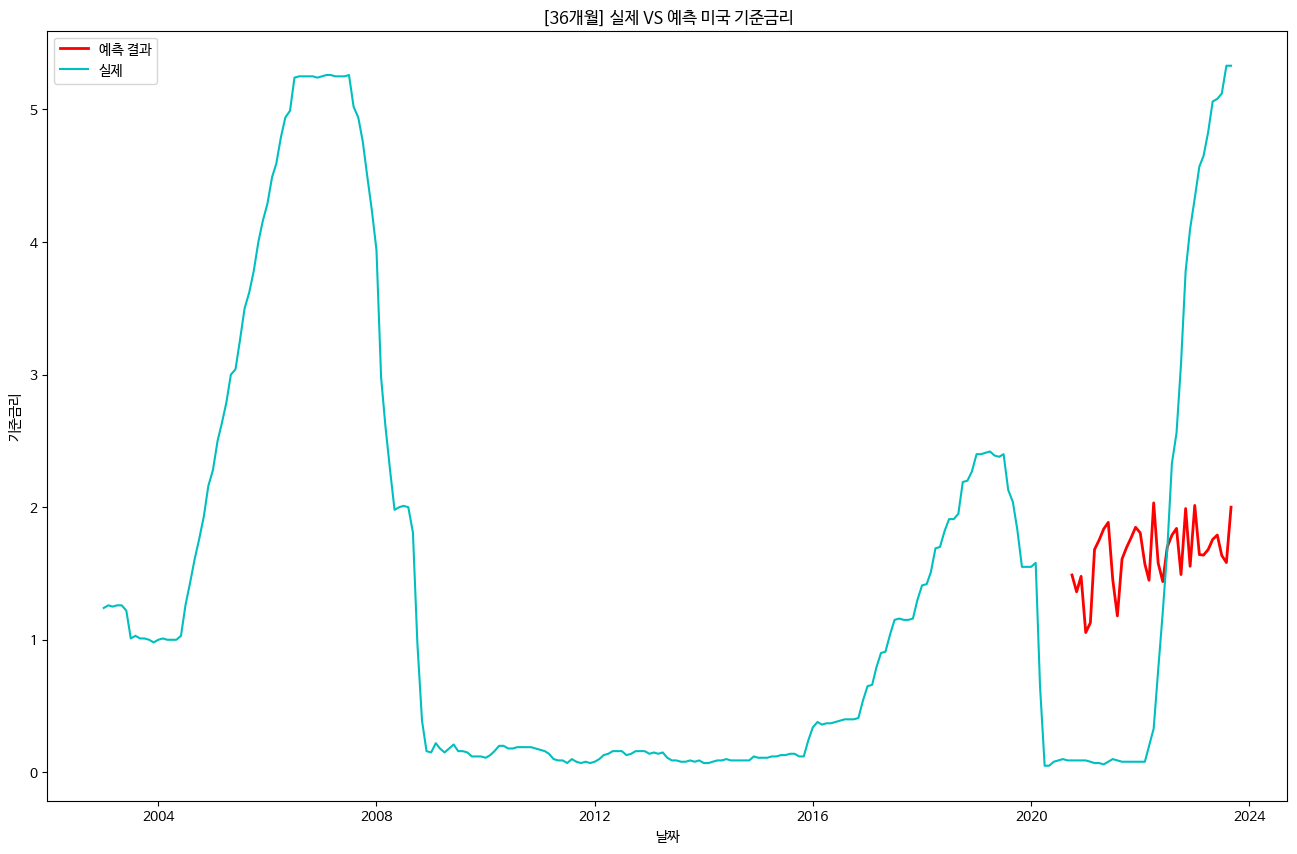

In [361]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['미_금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제', c = 'c')

plt.title('[36개월] 실제 VS 예측 미국 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [362]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="미_금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_053759'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.39 GB / 12.68 GB (81.9%)
Disk Space Avail:   191.51 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '미_금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [363]:
pred_36 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [364]:
pred_36

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  1.391259  0.083094  0.108099  0.148058  0.224894   
        2023-11-01  1.130678  0.064534  0.086287  0.140463  0.153866   
        2023-12-01  1.369512  0.059915  0.115425  0.173126  0.266522   
        2024-01-01  1.466989  0.047909  0.097918  0.148968  0.360375   
        2024-02-01  1.599397  0.027709  0.090971  0.154263  0.396775   
        2024-03-01  1.536176  0.018146  0.103936  0.159972  0.221677   
        2024-04-01  1.250961  0.018974  0.088538  0.146751  0.219938   
        2024-05-01  1.491335 -0.018079  0.054295  0.114534  0.218320   
        2024-06-01  1.440943  0.002554  0.058322  0.149332  0.225876   
        2024-07-01  1.316299 -0.004171  0.054093  0.146903  0.196118   
        2024-08-01  1.587272 -0.011087  0.049551  0.124828  0.175505   
        2024-09-01  1.822450 -0.027317  0.035589  0.131746  0.405142   
        2024-10-01  1.376922 -0.024033  0.031427  0.100285  0.201814   
        2024-11-01  1.333331 -0.030131  0.056290  0.136280  0.200608   
        2024-12-01  1.414450 -0.036016  0.023557  0.095382  0.189822   
        2025-01-01  1.373938 -0.051330  0.039065  0.112298  0.342659   
        2025-02-01  1.507628 -0.057393  0.025273  0.099872  0.225551   
        2025-03-01  1.511285 -0.034073  0.050432  0.126356  0.359017   
        2025-04-01  1.339425 -0.077772  0.018143  0.104979  0.204025   
        2025-05-01  1.351118 -0.083085  0.014572  0.083419  0.173915   
        2025-06-01  1.338224 -0.068788  0.020945  0.129507  0.192182   
        2025-07-01  1.594956 -0.063998  0.017771  0.127530  0.191227   
        2025-08-01  1.729962 -0.059099  0.014669  0.125597  0.401991   
        2025-09-01  1.660840 -0.089636 -0.004659  0.049677  0.192332   
        2025-10-01  1.077515 -0.094163 -0.007632  0.076693  0.162569   
        2025-11-01  1.610225 -0.098600 -0.010546  0.046009  0.190560   
        2025-12-01  1.115396 -0.105487 -0.015939  0.070561  0.158297   
        2026-01-01  1.264451 -0.109759 -0.018744  0.088059  0.167075   
        2026-02-01  1.131177 -0.113956 -0.011878  0.076719  0.147000   
        2026-03-01  1.121170 -0.127704 -0.033832  0.075031  0.155807   
        2026-04-01  1.047941 -0.151006 -0.026874  0.063748  0.135760   
        2026-05-01  1.266953 -0.145375 -0.029495  0.052492  0.154216   
        2026-06-01  1.601339 -0.130060 -0.022454  0.118242  0.201552   
        2026-07-01  1.114915 -0.124308 -0.034618  0.039677  0.152673   
        2026-08-01  1.516564 -0.128123 -0.027501  0.076607  0.382863   
        2026-09-01  1.817656 -0.141506 -0.039593  0.084691  0.382119   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  0.984318  1.166383  1.830200  2.187706  3.733088  
        2023-11-01  0.204884  0.457977  1.193078  2.209518  3.751648  
        2023-12-01  0.570544  1.317207  1.574188  2.286229  4.131550  
        2024-01-01  1.244129  1.425430  1.579101  2.419208  4.268651  
        2024-02-01  1.022808  1.437144  2.401354  2.984268  4.548663  
        2024-03-01  0.676393  1.034883  1.548852  4.539794  4.635207  
        2024-04-01  0.368469  0.940395  1.311885  2.322739  4.778718  
        2024-05-01  0.791865  0.951636  1.738630  2.433963  5.046715  
        2024-06-01  1.051130  1.241289  1.856701  2.428843  4.986498  
        2024-07-01  1.022808  1.185537  1.725506  2.078127  3.329598  
        2024-08-01  1.167148  1.918225  2.161355  2.390593  5.328401  
        2024-09-01  1.600167  2.044625  2.577833  3.636254  5.258028  
        2024-10-01  0.984318  1.189463  1.877973  2.264379  3.849838  
        2024-11-01  0.445450  1.575575  1.976695  2.278006  3.855937  
        2024-12-01  0.570544  1.576738  2.200424  2.349229  4.169746  
        2025-01-01  1.013186  1.443146  1.615771  2.478061  4.358267  
        2

In [365]:
for_plot_36 = pred_36.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-366-a6775ff59073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])


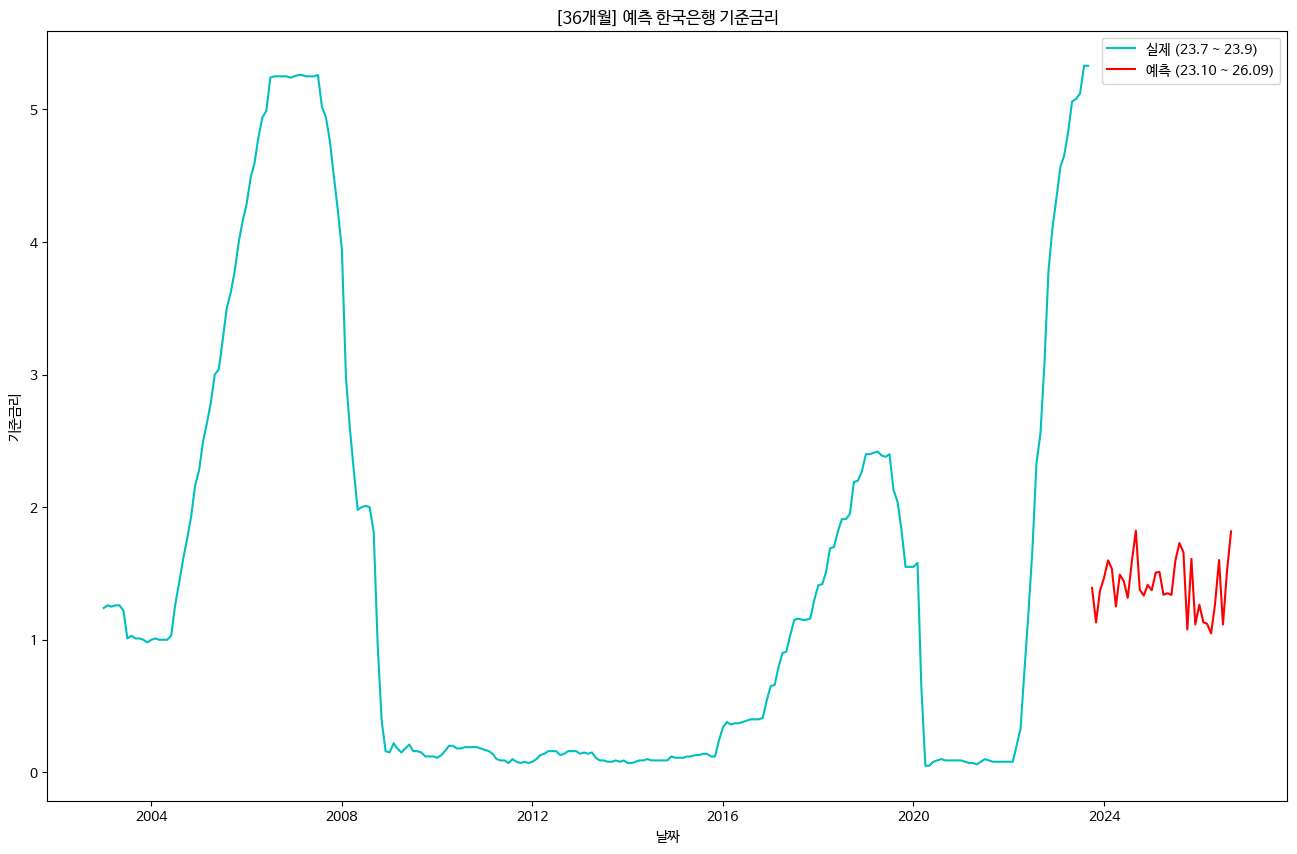

In [366]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_36['날짜'] = pd.to_datetime(for_plot_36['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['미_금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_36['날짜'], for_plot_36['mean'], label='예측 (23.10 ~ 26.09)', c = 'r')

plt.title('[36개월] 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

# [3] 최종 Validation, Prediction 값 저장

- 36개월간 예측 결과


In [391]:
a = for_plot_36.merge(for_plot_30, how = 'left', on = '날짜').merge(for_plot_24, how = 'left', on='날짜').rename(columns = {'mean_x' : 'mean_36', 'mean_y' : 'mean_30', 'mean' : 'mean_24'})

In [392]:
b = a.merge(for_plot_18, how = 'left', on = '날짜').merge(for_plot_12, how = 'left', on = '날짜').merge(for_plot_6, how = 'left', on = '날짜').rename(columns = {'mean_x' : 'mean_18', 'mean_y' : 'mean_12'})
c = b.merge(for_plot_3, how = 'left', on = '날짜').rename(columns = {'mean_x' : 'mean_6', 'mean_y':'mean_3'})

In [393]:
c

,날짜,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,2023-10-01,1.391259,1.395288,5.709195,3.981044,5.440958,5.305210,5.187369
1,2023-11-01,1.130678,1.139124,6.383365,4.074464,5.833009,5.312326,5.090091
2,2023-12-01,1.369512,1.353772,6.690510,4.275834,6.013081,5.317488,5.165521
3,2024-01-01,1.466989,1.474293,6.895930,4.385997,6.142523,5.321232,NaN
4,2024-02-01,1.599397,1.594993,7.098322,4.521171,6.277064,5.323948,NaN
5,2024-03-01,1.536176,1.547393,7.081927,4.523995,6.322384,5.325918,NaN
6,2024-04-01,1.250961,1.313598,7.175834,4.485361,6.424219,NaN,NaN
7,2024-05-01,1.491335,1.458338,7.277965,4.607309,6.296985,NaN,NaN
8,2024-06-01,1.440943,1.472614,7.205182,4.536202,6.229470,NaN,NaN
9,2024-07-01,1.316299,1.346098,7.200873,4.422859,6.251935,NaN,NaN


In [394]:
c.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/autogluon_result_ame_3.csv', index = False)

- 36개월간 validation 저장

In [395]:
val_result_ag = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag.csv', encoding = 'cp949')

In [396]:
val_result_ag.iloc[-3:, -1] = valid_3
val_result_ag.iloc[-6:, -2] = valid_6
val_result_ag.iloc[-12:, -3] = valid_12
val_result_ag.iloc[-18:, -4] = valid_18
val_result_ag.iloc[-24:, -5] = valid_24
val_result_ag.iloc[-30:, -6] = valid_30
val_result_ag.iloc[-36:, -7] = valid_36

In [397]:
val_result_ag

,Unnamed: 0,날짜,기준금리,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,0,2020-10-01,0.50,0.469610,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-11-01,0.50,0.379240,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-12-01,0.50,0.413742,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-01,0.50,0.390218,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-02-01,0.50,0.431239,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2021-03-01,0.50,0.423783,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2021-04-01,0.50,0.418617,0.933638,NaN,NaN,NaN,NaN,NaN
7,7,2021-05-01,0.50,0.406220,0.916571,NaN,NaN,NaN,NaN,NaN
8,8,2021-06-01,0.50,0.431504,0.889419,NaN,NaN,NaN,NaN,NaN
9,9,2021-07-01,0.50,0.397191,0.861296,NaN,NaN,NaN,NaN,NaN


In [398]:
val_result_ag.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag_ame_3.csv', encoding = 'cp949')